# PEGG 2.0

This is the real notebook for making the next generation of PEGG...

- Start with the flexible input + getting it to work WITH error checking, etc...
- I should translate everything into the easiest possible format to work with that is the most flexible...


- To do:
    - Get the flexible input format in PrimeDesign format working as well!
    - Have it detect what the input format is??
    - Or not?

In [26]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import Bio.Seq
import gzip
from Bio import SeqIO
from Bio.Align import PairwiseAligner
from Bio.pairwise2 import format_alignment
import warnings
import regex as re
warnings.filterwarnings('ignore')

In [22]:
MATCH_SCORE = 1
MISMATCH_SCORE = -0.5
OPEN_GAP_SCORE = -5
EXTEND_GAP_SCORE = -0.1
TARGET_END_GAP_SCORE = 0
QUERY_END_GAP_SCORE = 0

def make_aligner():
    aligner = PairwiseAligner()
    aligner.mode = 'global'
    aligner.match_score = MATCH_SCORE
    aligner.mismatch_score = MISMATCH_SCORE
    aligner.open_gap_score = OPEN_GAP_SCORE
    aligner.extend_gap_score = EXTEND_GAP_SCORE
    aligner.target_end_gap_score = TARGET_END_GAP_SCORE
    aligner.query_end_gap_score = QUERY_END_GAP_SCORE
    return aligner

aligner = make_aligner()

In [23]:
class mutation:
    def __init__(self, wt_w_context, alt_w_context, left_seq, right_seq, var_type, ref_seq, alt_seq, chrom=None, genome=None):
        """ 
        change seq_start and seq_end to correspond with chromosome coordinates
        or some other organizational method...
        """
        
        #WT sequence
        self.wt_forward = wt_w_context.upper()
        rc = str(Bio.Seq.Seq(self.wt_forward).reverse_complement())
        self.wt_rc = rc

        #ALT sequence
        self.mut_forward = alt_w_context.upper()
        rc_mut = str(Bio.Seq.Seq(self.mut_forward).reverse_complement())
        self.mut_rc = rc_mut

        #seq start refers to the WIDE sequence start (i.e. the WT sequence with e.g. 60 nt of context)
        self.seq_start = 0
        self.seq_end = len(self.wt_forward)
        self.chrom = chrom
        self.genome_build = genome

        #and splitting it up into the constituent components
        self.left_seq = left_seq.upper()
        self.right_seq = right_seq.upper()
        self.ref_seq = ref_seq.upper()
        self.alt_seq = alt_seq.upper()

        #and do the same to get it into the RC format

        #RIGHT/LEFT ARE SWAPPED ON REVERSE COMPLEMENT
        self.left_seq_rc = str(Bio.Seq.Seq(right_seq).reverse_complement())
        self.right_seq_rc = str(Bio.Seq.Seq(left_seq).reverse_complement())
        self.ref_seq_rc = str(Bio.Seq.Seq(ref_seq).reverse_complement())
        self.alt_seq_rc = str(Bio.Seq.Seq(alt_seq).reverse_complement())

        self.variant_type = var_type
        #self.alt_size = (positive or negative integer)
        
        #information about the PAM sequence location
        self.PAM_idx_forward = None
        self.PAM_idx_rc = None

In [24]:
left_seq = 'AAAA'
ref_seq = 'TGT'
alt_seq = 'CCC'
right_seq = 'TCTCTC'

wt_w_context = left_seq + ref_seq + right_seq
alt_w_context = left_seq + alt_seq + right_seq
print(alt_w_context)
print(Bio.Seq.Seq(alt_w_context).reverse_complement())

print(Bio.Seq.Seq(right_seq).reverse_complement() + Bio.Seq.Seq(alt_seq).reverse_complement() + Bio.Seq.Seq(left_seq).reverse_complement())

AAAACCCTCTCTC
GAGAGAGGGTTTT
GAGAGAGGGTTTT


In [25]:
#-----------functions------------
def genome_loader(filepath_gz):
    """
    Takes in filepath of human genome (GrCH37 or GrCh38) and returns records and index_list for PEGG parsing.
    
    Parameters
    -----------
    filepath_gz
        *type = str*
        
        The filepath to the .gz file holding the reference genome file.
    
    """
    #------loading in reference genome and organizing it into a 2-d list by chromosome---------------------
    wrong = ["alternate", "unplaced", "unlocalized", "patch", "mitochondrion"]
    filtered = []
    chrom_list = []
    seq_list = []

    with gzip.open(filepath_gz, "rt") as handle:
        #records = list(SeqIO.parse(handle, "fasta")) #about 4 Gb in  memory

        for i in SeqIO.parse(handle, "fasta"):
            ii = i.description
            ignore=False 

            for key in wrong:
                if key in ii:
                    ignore = True
            
            if ignore==False:

                x = ii.find('chromosome')
                chrom = ii[x:].split(' ')[1]
                chrom = chrom.split(',')[0]
                if chrom not in ['X', 'Y']:
                    chrom = int(chrom)
                chrom_list.append(chrom)
                seq_list.append(i.seq)

                filtered.append(ii)

  
    return dict(zip(chrom_list, seq_list)), filtered

In [26]:
filepath_37 = '/Users/samgould/Desktop/FSR Lab/reference files/GRCh37/ncbi-genomes-2022-03-17/GCF_000001405.25_GRCh37.p13_genomic.fna.gz'
filepath_38 = '/Users/samgould/Desktop/FSR Lab/reference files/GRCh38/ncbi-genomes-2022-02-23/GCF_000001405.26_GRCh38_genomic.fna.gz'
mouse = '/Users/samgould/Desktop/FSR Lab/reference files/GRCm38.p6 (mouse)/ncbi-genomes-2022-04-04/GCF_000001635.26_GRCm38.p6_genomic.fna.gz'
chrom_dict, i = genome_loader(filepath_37)

In [27]:
#starting by bringing in the code for extracting sequence

#need to modify this so that it works more generally (the chromosome shit in particular...)

def df_formatter(df, chrom_dict, context_size = 120, 
                 cols_to_save = ['Hugo_Symbol', 'Chromosome', 'Start_Position', 'End_Position', 'Consequence', 'Variant_Classification', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele2',  'HGVSc', 'HGVSp_Short']):

    """ 
    Takes in variants (in cBioPortal format!)
    and outputs dataframe with WT and ALT oligos with designated context_size
    context_size = the amount of nt on either side of the variant e.g. AAA(A/G)AAA = context_size of 3
    cols_to_save = information to save about the mutations...(can modify beyond defaults...)
    """

    wt_w_context = []
    alt_w_context = []
    left_context_list = []
    right_context_list = []
    ref_allele = []
    alt_allele = []

    seq_start = []
    seq_end = []

    for i, val in df.iterrows():
        vt = val['Variant_Type']
        s = val['Start_Position']
        e = val['End_Position']
        ref = val['Reference_Allele']
        alt = val['Tumor_Seq_Allele2']
        chrom = val['Chromosome']

        if chrom not in ['X','Y']:
            chrom = int(chrom)
       
        chr_seq = chrom_dict[chrom].upper()

        if vt in ['SNP', 'ONP', 'DNP']:
            ref = ref
            alt = alt
            #assert ref == chr_seq[s-1:e], print(ref, chr_seq[s-1:e])
            left_context = chr_seq[s-1-context_size:s-1]
            right_context = chr_seq[e:e+context_size]

        elif vt =='INS':
            ref = ''
            alt = alt
            #left_context = chr_seq[s-1-context_size:s+1] #need to do this since INS reference alleles are blank
            left_context = chr_seq[s-1-context_size:s]
            right_context = chr_seq[e-1:e+context_size]

        elif vt=='DEL':
            ref = ref
            alt = ''
            left_context = chr_seq[s-1-context_size:s-1]
            right_context = chr_seq[e:e+context_size]

        wt_seq = left_context + ref + right_context
        alt_seq = left_context + alt + right_context

        wt_w_context.append(str(wt_seq))
        alt_w_context.append(str(alt_seq))
        left_context_list.append(str(left_context))
        right_context_list.append(str(right_context))
        ref_allele.append(str(ref))
        alt_allele.append(str(alt))

        start = s-context_size
        end = e+context_size

        seq_start.append(start)
        seq_end.append(end)

        assert str(chr_seq[start-1:end])==str(wt_seq), print(chr_seq[start-1:end] + '\n' + str(wt_seq))
                                                            

    df_new = df[cols_to_save]

    df_new['seq_start'] = seq_start
    df_new['seq_end'] = seq_end
    df_new['wt_w_context'] = wt_w_context
    df_new['alt_w_context'] = alt_w_context
    df_new['left_context'] = left_context_list
    df_new['right_context'] = right_context_list
    df_new['REF'] = ref_allele
    df_new['ALT'] = alt_allele
    df_new = df_new.reset_index()
    
    return df_new


In [28]:
impact = pd.read_csv('/Users/samgould/Desktop/FSR Lab/reference files/2020-06-16-MSK-IMPACT_EDITED.txt', sep='\t')


In [181]:
p53 = impact[impact['Hugo_Symbol']=='TP53'].drop_duplicates(subset='HGVSc')

#or change these to INDELs
dels1 = p53[p53['Variant_Type']=='DEL']
bad_del_idx = list(dels1[dels1['Tumor_Seq_Allele2']!='-'].index)


ins1 = p53[p53['Variant_Type']=='INS']
bad_ins_idx = list(ins1[ins1['Reference_Allele']!='-'].index)

bad_idxs = bad_del_idx + bad_ins_idx

p53_filtered = p53.drop(index=bad_idxs).reset_index().drop(columns=['index'])

p53_formatted = df_formatter(p53_filtered, chrom_dict)

In [183]:
p53_formatted

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,HGVSc,HGVSp_Short,seq_start,seq_end,wt_w_context,alt_w_context,left_context,right_context,REF,ALT
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,ENST00000269305.4:c.818G>A,p.R273H,7577060,7577180,CCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAG...,CCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAG...,CCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAG...,GCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGAT...,C,T
1,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,ENST00000269305.4:c.830G>T,p.C277F,7577048,7577168,TGGTGAGGCTCCCCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCC...,TGGTGAGGCTCCCCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCC...,TGGTGAGGCTCCCCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCC...,AGGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACC...,C,A
2,2,TP53,17,7578239,7578239,stop_gained,Nonsense_Mutation,SNP,C,A,ENST00000269305.4:c.610G>T,p.E204*,7578179,7578299,CAGGCGGCTCATAGGGCACCACCACACTATGTCGAAAAGTGTTTCT...,CAGGCGGCTCATAGGGCACCACCACACTATGTCGAAAAGTGTTTCT...,CAGGCGGCTCATAGGGCACCACCACACTATGTCGAAAAGTGTTTCT...,CACACGCAAATTTCCTTCCACTCGGATAAGATGCTGAGGAGGGGCC...,C,A
3,3,TP53,17,7577121,7577121,missense_variant,Missense_Mutation,SNP,G,A,ENST00000269305.4:c.817C>T,p.R273C,7577061,7577181,CTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAGG...,CTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAGG...,CTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAGG...,CACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGATA...,G,A
4,4,TP53,17,7577506,7577506,missense_variant,Missense_Mutation,SNP,C,A,ENST00000269305.4:c.775G>T,p.D259Y,7577446,7577566,GCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGCAAGTGGC...,GCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGCAAGTGGC...,GCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGCAAGTGGC...,TTCCAGTGTGATGATGGTGAGGATGGGCCTCCGGTTCATGCCGCCC...,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000,3000,TP53,17,7577539,7577541,inframe_deletion,In_Frame_Del,DEL,GGT,-,ENST00000269305.4:c.740_742del,p.N247del,7577479,7577601,GGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGT...,GGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGT...,GGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGT...,TCATGCCGCCCATGCAGGAACTGTTACACATGTAGTTGTAGTGGAT...,GGT,
3001,3001,TP53,17,7578438,7578438,missense_variant,Missense_Mutation,SNP,C,G,ENST00000269305.4:c.492G>C,p.K164N,7578378,7578498,ATCTGAGCAGCGCTCATGGTGGGGGCAGCGCCTCACAACCTCCGTC...,ATCTGAGCAGCGCTCATGGTGGGGGCAGCGCCTCACAACCTCCGTC...,ATCTGAGCAGCGCTCATGGTGGGGGCAGCGCCTCACAACCTCCGTC...,TTGTAGATGGCCATGGCGCGGACGCGGGTGCCGGGCGGGGGTGTGG...,C,G
3002,3002,TP53,17,7577531,7577532,frameshift_variant,Frame_Shift_Del,DEL,GG,-,ENST00000269305.4:c.749_750delCC,p.P250Hfs*13,7577471,7577592,GTGTGCAGGGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTG...,GTGTGCAGGGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTG...,GTGTGCAGGGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTG...,GCCTCCGGTTCATGCCGCCCATGCAGGAACTGTTACACATGTAGTT...,GG,
3003,3003,TP53,17,7578421,7578440,frameshift_variant,Frame_Shift_Del,DEL,GTCATGTGCTGTGACTGCTT,-,ENST00000269305.4:c.490_509del,p.K164Gfs*10,7578361,7578500,AGCTGCTCACCATCGCTATCTGAGCAGCGCTCATGGTGGGGGCAGC...,AGCTGCTCACCATCGCTATCTGAGCAGCGCTCATGGTGGGGGCAGC...,AGCTGCTCACCATCGCTATCTGAGCAGCGCTCATGGTGGGGGCAGC...,GTAGATGGCCATGGCGCGGACGCGGGTGCCGGGCGGGGGTGTGGAA...,GTCATGTGCTGTGACTGCTT,


# Flexible input format

- Get this working so that you can also put in sequences in PrimeDesign format AND in for just inputting the ref and mutant seq

- Need to get out the indeces as well? or can just count the size

In [29]:
def mut_formatter(wt, alt):

    alignments = aligner.align(wt, alt)

    WT_align = alignments[0].aligned[0]
    alt_align = alignments[0].aligned[1]

    if len(WT_align) == 1:
        #Substitution (SNP or ONP)

        #find indexes of non-matching values to get right/left context sequences and mutant sequence
        non_matching_idx = []

        for i, val in enumerate(list(zip(wt, alt))):
            if val[0] != val[1]:
                non_matching_idx.append(i)
        
        assert len(non_matching_idx) !=0, f'No mutation detected in alt sequence provided | row index = {i}'

        if len(non_matching_idx)==1:
            var_type = 'SNP'
        else:
            var_type = 'ONP'

        left_seq = wt[:non_matching_idx[0]]
        ref_seq = wt[non_matching_idx[0]:non_matching_idx[-1]+1]
        alt_seq = alt[non_matching_idx[0]:non_matching_idx[-1]+1]
        right_seq = wt[non_matching_idx[-1]+1:]


    elif len(WT_align)>1:
        if len(alt)>len(wt):
            var_type = 'INS'
        elif len(alt)<len(wt):
            var_type='DEL'

        left_seq = wt[WT_align[0][0]:WT_align[0][1]]
        right_seq = wt[WT_align[1][0]:WT_align[1][1]]

        if var_type=='INS':
        #INS or DEL
            ref_seq = ''
            alt_seq = alt[alt_align[0][1]:alt_align[1][0]]
            
        elif var_type =='DEL':
            ref_seq = wt[WT_align[0][1]:WT_align[1][0]]
            alt_seq = ''
            

    return var_type, left_seq, ref_seq, alt_seq, right_seq
    print(var_type)
    print(left_seq)
    print(f'REF: {ref_seq}')
    print(f'ALT: {alt_seq}')
    print(right_seq)

    #print(alignments[0])
    #this program will break for complex substitutions

In [30]:
def primedesign_formatter(seq):
    """ 
    takes as input sequence in prime design format 
    e.g. AATTCCG(G/C)AATTCGCT
    """

    start = seq.find("(")

    end = seq.find(")")

    replace_seq = seq[start:end+1]
    #if '/' in replace_seq:
        #if '+' in replace_seq:
            #throw an error

    loc_replace = replace_seq.find('/')
    ref_seq = replace_seq[1:loc_replace]
    alt_seq = replace_seq[loc_replace+1:-1]

    left_seq = seq[:start]
    right_seq = seq[end+1:]

    wt_w_context = left_seq + ref_seq + right_seq
    alt_w_context = left_seq + alt_seq + right_seq

    if len(ref_seq)==0:
        var_type='INS'

    else:
        if len(ref_seq)==len(alt_seq):
            if len(ref_seq)==1:
                var_type='SNP'
            else:
                var_type='ONP'

        else:
            if len(alt_seq) == 0:
                var_type = 'DEL'
            else:
                var_type = 'INDEL'

    return var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq

In [31]:
seq = 'AATTCGTCGTAGC(G/)TCGGCTAGCTAGCTGGCA'
var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq = primedesign_formatter(seq)

# PAM searching

- Idea is to only do everything with respect to the forward strand
- Not code a bespoke solution for the reverse complement strand
- And just fix the coordinates afterward (translate them to the forward strand coordinates)

In [32]:
def PAM_finder(seq, PAM):
    """ 
    Finds indeces of PAM sequences
    Formatting: e.g. "NGG"
    N = [A|T|C|G]
    R = [A|G]
    Y = [C|T]
    S = [G|C]
    W = [A|T]
    K = [G|T]
    M = [A|C]
    B = [C|G|T]
    D = [A|G|T]
    H = [A|C|T]
    V = [A|C|G]
    """
    PAM_dict = {"A":"A",
                "G":"G",
                "C":"C",
                "T":"T",
                "N":"[A|T|C|G]",
                "R":"[A|G]",
                "Y":"[C|T]",
                "S":"[G|C]",
                "W":"[A|T]",
                "K":"[G|T]",
                "M":"[A|C]",
                "B":"[C|G|T]",
                "D":"[A|G|T]",
                "H":"[A|C|T]",
                "V":"[A|C|G]"}

    PAM_new = ""
    for i in PAM:
        PAM_new += PAM_dict[i]

    p = re.compile(PAM_new)

    iterator = p.finditer(seq, overlapped=True)
    PAM_holder = []
    for match in iterator:
        PAM_holder.append(match.span())

    return PAM_holder

In [25]:
PAM = 'NGG'
seq = 'GGGGTGGG'
PAM_holder = PAM_finder(seq, PAM)

for i in PAM_holder:
    print(i[0], i[1], seq[i[0]:i[1]])

0 3 GGG
1 4 GGG
4 7 TGG
5 8 GGG


In [249]:
PAM_holder

[(18, 21), (30, 33)]

In [26]:
PAM = 'NGG'

#seq = 'ATGATGCGCGGCTAGAATTCGTTGGCGTAGCGTAGCGT(G/)TCTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA'
seq = 'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTT(ACG/GCA)TGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA'

var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq = primedesign_formatter(seq)


PAM_holder = PAM_finder(wt_w_context, PAM)

for i in PAM_holder:
    print(wt_w_context[i[0]:i[1]])

ONP
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTGCATGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
LEFT: GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTT
REF: ACG
ALT: GCA
RIGHT: TGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
TGG
TGG
TGG
TGG
TGG
TGG
TGG


In [502]:
len('CGTAAGCGT')

9

In [505]:
#searching for PAM sequences on the FORWARD STRAND

#search on max_RTT_length - 

left_len = len(left_seq)
right_len = len(right_seq)
max_RTT_length = 20

if var_type =='INS':
    alt_size = len(alt_seq)
    m_start = left_len - (max_RTT_length - alt_size - 3)
    m_end = left_len + 4

else:
    ref_size = len(ref_seq)
    alt_size = len(alt_seq)
    m_start = left_len - (max_RTT_length - alt_size - 3)
    m_end = left_len + 3

proto_size = 19

eligible_PAM_start = max(m_start, proto_size + 3) #
eligible_PAM_end = m_end

eligible_PAMS = []
for i in PAM_holder:
    #check start of PAM site
    s = i[0]
    if (s>=eligible_PAM_start) and (s<=eligible_PAM_end):
        eligible_PAMS.append(i)

eligible_PAMS



[(26, 29), (43, 46)]

In [506]:
for i in eligible_PAMS:
    s = i[0]
    alignments = aligner.align(wt_w_context[s:], wt_w_context)

    print(alignments[0])

    alignments2 = aligner.align(wt_w_context, alt_w_context)
    print(alignments2[0])


--------------------------GGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
--------------------------|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
||||||||||||||||||||||||||||||||||||||||.|.||||||||||||||||||||||||||||||||||||||||||
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTGCATGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA

-------------------------------------------TGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
-------------------------------------------||||||||||||||||||||||||||||||||||||||||||
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
||||||||||||||||||||||||||||||||||||||||.|.||||||||||||||||||||||||||||||||||||||||||
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTGCATGGCTAGC

In [492]:
len('GGGCGTAAGCGTTTACG')

17

In [86]:
seq = p53_formatted.iloc[0]['wt_w_context']
print(seq)
PAM = "NRCH"
PAM_holder = PAM_finder(seq, PAM)

for i in PAM_holder:
    print(seq[i[0]:i[1]])

CCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAGGACAGGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGATAGGAAAAGAGAAGC
CGCC
GACA
GGCA
AACA
CGCA
AGCT
TACC
TACT


# Putting some things together

In [27]:
seq = 'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTT(ATGG/)TAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA'

var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq = primedesign_formatter(seq)
mut = mutation(wt_w_context, alt_w_context, left_seq, right_seq, var_type, ref_seq, alt_seq, chrom=None, genome=None)

DEL
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTATGGTAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTTAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
LEFT: GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTT
REF: ATGG
ALT: 
RIGHT: TAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA


In [33]:
def eligible_PAM_finder(mut, PAM, max_RTT_length, proto_size=19):
    """ 
    Determines eligible PAM sequences for creating pegRNAs...

    """

    forward = PAM_finder(mut.wt_forward, PAM)
    reverse = PAM_finder(mut.wt_rc, PAM)


    #first do the forward sequence
    left_len_F = len(mut.left_seq)
    left_len_R = len(mut.left_seq_rc)

    if var_type =='INS':
        alt_size = len(mut.alt_seq)
        m_start_F = left_len_F - (max_RTT_length - alt_size - 3)
        m_end_F = left_len_F + 4
        
        m_start_R = left_len_R - (max_RTT_length - alt_size - 3)
        m_end_R = left_len_R + 4

    else:
        alt_size = len(mut.alt_seq)
        m_start_F = left_len_F - (max_RTT_length - alt_size - 3)
        m_end_F = left_len_F + 3

        m_start_R = left_len_R - (max_RTT_length - alt_size - 3)
        m_end_R = left_len_R + 3


    eligible_PAM_start_F = max(m_start_F, proto_size + 3) #
    eligible_PAM_end_F = m_end_F
    
    eligible_PAM_start_R = max(m_start_R, proto_size + 3) #
    eligible_PAM_end_R = m_end_R

    eligible_PAMS_F = []
    eligible_PAMS_R = []

    for i in forward:
        #check start of PAM site
        s = i[0]
        if (s>=eligible_PAM_start_F) and (s<=eligible_PAM_end_F):
            eligible_PAMS_F.append(i)

    for i in reverse:
        #check start of PAM site
        s = i[0]
        if (s>=eligible_PAM_start_R) and (s<=eligible_PAM_end_R):
            eligible_PAMS_R.append(i)

    return eligible_PAMS_F, eligible_PAMS_R

    

In [29]:
#eligible PAM finding
PAM = "NGG"
max_RTT_length = 20
proto_size = 10

mut.PAM_idx_forward = PAM_finder(mut.wt_forward, PAM)
mut.PAM_idx_rc = PAM_finder(mut.wt_rc, PAM)

mut.PAM_idx_forward, mut.PAM_idx_rc = eligible_PAM_finder(mut, PAM, max_RTT_length, proto_size)
#mut.PAM_idx_forward
#mut.PAM_idx_rc

In [30]:
mut.PAM_idx_forward

[(23, 26), (24, 27), (25, 28), (26, 29), (41, 44)]

In [31]:
mut.PAM_idx_rc

[(33, 36)]

# pegRNA design

In [104]:
def pegRNA_generator(mut, PAM, orientation, proto_size, RTT_lengths, PBS_lengths):
    #------function----
    protospacer_seqs = []
    protospacer_wide_seqs = []
    PAM_start_list = []
    PAM_end_list = []
    PAM_list = []

    RTT_seqs = []
    RTT_size = []
    PBS_seqs = []
    PBS_size = []
    RTT_PBS_seqs = []

    #descriptors of pegRNAs...
    distance_to_nick = [] #distance from the start of the mutation to the nick introduced by nCas9 (-3 from PAM)
    RHA = [] #right homology arm (distance from end of mutation to end of RTT)
    PAM_disrupted_list = []
    proto_disrupted_list = []

    #Get mutation info, depending on whether we're looking on the + or the - strand
    if orientation == '+':
        left_len = len(mut.left_seq)
        ref_len = len(mut.ref_seq)
        alt_len = len(mut.alt_seq)
        alt_seq = mut.alt_seq
        seq_F = mut.wt_forward

        PAM_seqs = mut.PAM_idx_forward

    elif orientation == '-':
        left_len = len(mut.left_seq_rc)
        ref_len = len(mut.ref_seq_rc)
        alt_len = len(mut.alt_seq_rc)
        alt_seq = mut.alt_seq_rc
        seq_F = mut.wt_rc

        PAM_seqs = mut.PAM_idx_rc

    #iterate over the PAM sequences:
    for i in PAM_seqs:
        PAM_start = i[0]
        PAM_end = i[1]

        RTT_start = PAM_start - 3

        left_RTT = seq_F[RTT_start:left_len]

        for RTT_length in RTT_lengths:

            remaining_length = RTT_length - (len(left_RTT) + alt_len)

            #make sure RTT is long enough
            #and make sure that there's sufficient sequence to actually pull from...
            if (remaining_length <0) or ((left_len+ref_len + remaining_length) > len(seq_F)):
                RTT_seqs.append(None)
                distance_to_nick.append(None)
                RHA.append(None)
                PAM_disrupted_list.append(None)
                proto_disrupted_list.append(None)
                PAM_start_list.append(None)
                PAM_end_list.append(None)
                PAM_list.append(None)
                protospacer_seqs.append(None)
                protospacer_wide_seqs.append(None)
                PBS_seqs.append(None)
                RTT_PBS_seqs.append(None)
                RTT_size.append(None)
                PBS_size.append(None)

            else: #able to design the pegRNA

                right_RTT = seq_F[left_len+ref_len:left_len+ref_len + remaining_length]
                RTT = left_RTT + alt_seq + right_RTT

                #and then determine if the PAM sequence is disrupted
                #protospacer disrupted would just be if the distance to nick is < 3
                #fish out the PAM sequence from RTT
                PAM_new = RTT[3:3+len(PAM)]
                pam_list = PAM_finder(PAM_new, PAM)

                PAM_disrupted = False
                if len(pam_list)==0:
                    PAM_disrupted = True

                proto_disrupted = False
                if len(left_RTT) < 3:
                    proto_disrupted = True

                #and finally reverse complement the RTT
                RTT = str(Bio.Seq.Seq(RTT).reverse_complement())

                #pull out the PAM sequence and protospacer as well
                PAM_sequence = seq_F[PAM_start:PAM_end]
                protospacer =  'G' + seq_F[PAM_start - proto_size:PAM_start]

                #extract wide protospacer for Rule set 2 prediction...
                protospacer_wide = seq_F[PAM_start - 20 - 4 : PAM_start + 3 + 3]
                
                #iterate over PBS lengths for adding things to list
                for PBS_length in PBS_lengths:
                    RTT_seqs.append(RTT)
                    RTT_size.append(RTT_length)
                    PBS_size.append(PBS_length)
                    distance_to_nick.append(len(left_RTT))
                    RHA.append(len(right_RTT))
                    PAM_disrupted_list.append(PAM_disrupted)
                    proto_disrupted_list.append(proto_disrupted)

                    #------add in PAM info, protospacer, + PBS/RTT_PBS
                    #record info about PAM sequences
                    if orientation == '+':
                        PAM_start_list.append(PAM_start)
                        PAM_end_list.append(PAM_end)
                    elif orientation == '-':
                        PAM_start_list.append(len(seq_F)-PAM_start)
                        PAM_end_list.append(len(seq_F)-PAM_end)

                    PAM_list.append(PAM_sequence)
                    protospacer_seqs.append(protospacer)
                    protospacer_wide_seqs.append(protospacer_wide)

                    #----and finally design the PBS sequences----
                    #NEED TO HAVE AN ERROR MESSAGE FOR PBS SEQUENCES LARGER THAN 17
                    PBS = seq_F[RTT_start-PBS_length:RTT_start]
                    PBS = str(Bio.Seq.Seq(PBS).reverse_complement())
                    PBS_seqs.append(PBS)

                    #---and then add it to the RTT to make the full 3' extension
                    RTT_PBS_seqs.append(RTT+PBS)

    cols = [PAM_start_list, PAM_end_list, PAM_list, orientation, protospacer_wide_seqs, protospacer_seqs, RTT_seqs, RTT_size, PBS_seqs, PBS_size, RTT_PBS_seqs, distance_to_nick, RHA, PAM_disrupted_list, proto_disrupted_list]
    col_labels = ["PAM_start", "PAM_end", "PAM", "PAM_strand","Protospacer_30", "Protospacer", "RTT", "RTT_length", "PBS", "PBS_length", "RTT_PBS", "Distance_to_nick", "RHA_size", "PAM_disrupted", "Proto_disrupted"]
    dtypes = ['int', 'int', 'str', 'str', 'str', 'str', 'str', 'int', 'str', 'int', 'str', 'int', 'int', 'bool', 'bool']

    dtype_dict = dict(zip(col_labels, dtypes))

    peg_df = pd.DataFrame(dict(zip(col_labels, cols))).dropna().reset_index().drop(columns='index').astype(dtype_dict)

    return peg_df

In [113]:
#mutation info
seq = 'ATGCGATGCGAGCTAGCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTT(ATGG/)TAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCACGATGCGGATCGAGC'
PAM = "NGG"
#--params
RTT_lengths = [10,20,30]
PBS_lengths = [10,13, 15,17]
orientation = '-'
proto_size = 19

max_RTT_length = max(RTT_lengths)

var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq = primedesign_formatter(seq)
mut = mutation(wt_w_context, alt_w_context, left_seq, right_seq, var_type, ref_seq, alt_seq, chrom=None, genome=None)
mut.PAM_idx_forward, mut.PAM_idx_rc = eligible_PAM_finder(mut, PAM, max_RTT_length, proto_size)



peg_df_plus = pegRNA_generator(mut, PAM, '+', proto_size, RTT_lengths, PBS_lengths)
peg_df_minus = pegRNA_generator(mut, PAM, '-', proto_size, RTT_lengths, PBS_lengths)

#need to translate PAM indexing for the - strand!!!!
#convert to genome coordinates as well...
pd.concat((peg_df_plus, peg_df_minus)).reset_index().drop(columns='index')

,PAM_start,PAM_end,PAM,PAM_strand,Protospacer_30,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
0,30,33,GGG,+,TGCGAGCTAGCGGGGGGGGGGGGGGGGGGG,GGCTAGCGGGGGGGGGGGGG,AAACGCTTACGCCCCCCCCCCCCCCCCCCC,30,CCCCCCCCCC,10,AAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,30,0,False,False
1,30,33,GGG,+,TGCGAGCTAGCGGGGGGGGGGGGGGGGGGG,GGCTAGCGGGGGGGGGGGGG,AAACGCTTACGCCCCCCCCCCCCCCCCCCC,30,CCCCCCCCCCGCT,13,AAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGCT,30,0,False,False
2,30,33,GGG,+,TGCGAGCTAGCGGGGGGGGGGGGGGGGGGG,GGCTAGCGGGGGGGGGGGGG,AAACGCTTACGCCCCCCCCCCCCCCCCCCC,30,CCCCCCCCCCGCTAG,15,AAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGCTAG,30,0,False,False
3,30,33,GGG,+,TGCGAGCTAGCGGGGGGGGGGGGGGGGGGG,GGCTAGCGGGGGGGGGGGGG,AAACGCTTACGCCCCCCCCCCCCCCCCCCC,30,CCCCCCCCCCGCTAGCT,17,AAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGCTAGCT,30,0,False,False
4,31,34,GGG,+,GCGAGCTAGCGGGGGGGGGGGGGGGGGGGG,GCTAGCGGGGGGGGGGGGGG,AAAACGCTTACGCCCCCCCCCCCCCCCCCC,30,CCCCCCCCCC,10,AAAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCCCCCCC,29,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,74,71,AGG,-,ATGCCATGCCATGCCATGCCAGCTAGGCTA,GATGCCATGCCATGCCAGCT,GTTTTAGTAGCTAGCCTAGC,20,TGGCATGGCATGGCATG,17,GTTTTAGTAGCTAGCCTAGCTGGCATGGCATGGCATG,16,4,False,False
88,74,71,AGG,-,ATGCCATGCCATGCCATGCCAGCTAGGCTA,GATGCCATGCCATGCCAGCT,GGGCGTAAGCGTTTTAGTAGCTAGCCTAGC,30,TGGCATGGCA,10,GGGCGTAAGCGTTTTAGTAGCTAGCCTAGCTGGCATGGCA,16,14,False,False
89,74,71,AGG,-,ATGCCATGCCATGCCATGCCAGCTAGGCTA,GATGCCATGCCATGCCAGCT,GGGCGTAAGCGTTTTAGTAGCTAGCCTAGC,30,TGGCATGGCATGG,13,GGGCGTAAGCGTTTTAGTAGCTAGCCTAGCTGGCATGGCATGG,16,14,False,False
90,74,71,AGG,-,ATGCCATGCCATGCCATGCCAGCTAGGCTA,GATGCCATGCCATGCCAGCT,GGGCGTAAGCGTTTTAGTAGCTAGCCTAGC,30,TGGCATGGCATGGCA,15,GGGCGTAAGCGTTTTAGTAGCTAGCCTAGCTGGCATGGCATGGCA,16,14,False,False


In [111]:
s = 'GGGGGGGGGGGGGGGGGGGGGGGGGGGCGT'
s[24:27]

'GGG'

In [112]:
len(s)

30

In [34]:
alignments2 = aligner.align(mut.wt_rc, 
                            'GATGCCATGCCATGCCAGCT')
print(alignments2[0])

TGCCATGCCATGCCATGCCATGCCATGCCAGCTAGGCTAGCTACTACCATAAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
-------------.|||||||||||||||||||---------------------------------------------------------
-------------GATGCCATGCCATGCCAGCT---------------------------------------------------------



# Testing on larger set

In [115]:
p53 = impact[impact['Hugo_Symbol']=='TP53'].drop_duplicates(subset='HGVSc')

#or change these to INDELs
dels1 = p53[p53['Variant_Type']=='DEL']
bad_del_idx = list(dels1[dels1['Tumor_Seq_Allele2']!='-'].index)


ins1 = p53[p53['Variant_Type']=='INS']
bad_ins_idx = list(ins1[ins1['Reference_Allele']!='-'].index)

bad_idxs = bad_del_idx + bad_ins_idx

p53_filtered = p53.drop(index=bad_idxs).reset_index().drop(columns=['index'])

p53_formatted = df_formatter(p53_filtered, chrom_dict, context_size=100)


KeyboardInterrupt: 

In [38]:
input_df = p53_formatted

In [39]:
input_df

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,HGVSc,HGVSp_Short,seq_start,seq_end,wt_w_context,alt_w_context,left_context,right_context,REF,ALT
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,ENST00000269305.4:c.818G>A,p.R273H,7577020,7577220,TCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTC...,TCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTC...,TCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTC...,GCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGAT...,C,T
1,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,ENST00000269305.4:c.830G>T,p.C277F,7577008,7577208,TGCTTGCTTACCTCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGA...,TGCTTGCTTACCTCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGA...,TGCTTGCTTACCTCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGA...,AGGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACC...,C,A
2,2,TP53,17,7578239,7578239,stop_gained,Nonsense_Mutation,SNP,C,A,ENST00000269305.4:c.610G>T,p.E204*,7578139,7578339,TAACCCCTCCTCCCAGAGACCCCAGTTGCAAACCAGACCTCAGGCG...,TAACCCCTCCTCCCAGAGACCCCAGTTGCAAACCAGACCTCAGGCG...,TAACCCCTCCTCCCAGAGACCCCAGTTGCAAACCAGACCTCAGGCG...,CACACGCAAATTTCCTTCCACTCGGATAAGATGCTGAGGAGGGGCC...,C,A
3,3,TP53,17,7577121,7577121,missense_variant,Missense_Mutation,SNP,G,A,ENST00000269305.4:c.817C>T,p.R273C,7577021,7577221,CGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTCT...,CGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTCT...,CGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTCT...,CACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGATA...,G,A
4,4,TP53,17,7577506,7577506,missense_variant,Missense_Mutation,SNP,C,A,ENST00000269305.4:c.775G>T,p.D259Y,7577406,7577606,GAAGAAATCGGTAAGAGGTGGGCCCAGGGGTCAGAGGCAAGCAGAG...,GAAGAAATCGGTAAGAGGTGGGCCCAGGGGTCAGAGGCAAGCAGAG...,GAAGAAATCGGTAAGAGGTGGGCCCAGGGGTCAGAGGCAAGCAGAG...,TTCCAGTGTGATGATGGTGAGGATGGGCCTCCGGTTCATGCCGCCC...,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000,3000,TP53,17,7577539,7577541,inframe_deletion,In_Frame_Del,DEL,GGT,-,ENST00000269305.4:c.740_742del,p.N247del,7577439,7577641,GAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGC...,GAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGC...,GAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGC...,TCATGCCGCCCATGCAGGAACTGTTACACATGTAGTTGTAGTGGAT...,GGT,
3001,3001,TP53,17,7578438,7578438,missense_variant,Missense_Mutation,SNP,C,G,ENST00000269305.4:c.492G>C,p.K164N,7578338,7578538,AGCCCTGTCGTCTCTCCAGCCCCAGCTGCTCACCATCGCTATCTGA...,AGCCCTGTCGTCTCTCCAGCCCCAGCTGCTCACCATCGCTATCTGA...,AGCCCTGTCGTCTCTCCAGCCCCAGCTGCTCACCATCGCTATCTGA...,TTGTAGATGGCCATGGCGCGGACGCGGGTGCCGGGCGGGGGTGTGG...,C,G
3002,3002,TP53,17,7577531,7577532,frameshift_variant,Frame_Shift_Del,DEL,GG,-,ENST00000269305.4:c.749_750delCC,p.P250Hfs*13,7577431,7577632,AGGGGTCAGAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGC...,AGGGGTCAGAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGC...,AGGGGTCAGAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGC...,GCCTCCGGTTCATGCCGCCCATGCAGGAACTGTTACACATGTAGTT...,GG,
3003,3003,TP53,17,7578421,7578440,frameshift_variant,Frame_Shift_Del,DEL,GTCATGTGCTGTGACTGCTT,-,ENST00000269305.4:c.490_509del,p.K164Gfs*10,7578321,7578540,GGGGACCCTGGGCAACCAGCCCTGTCGTCTCTCCAGCCCCAGCTGC...,GGGGACCCTGGGCAACCAGCCCTGTCGTCTCTCCAGCCCCAGCTGC...,GGGGACCCTGGGCAACCAGCCCTGTCGTCTCTCCAGCCCCAGCTGC...,GTAGATGGCCATGGCGCGGACGCGGGTGCCGGGCGGGGGTGTGGAA...,GTCATGTGCTGTGACTGCTT,


In [114]:
#--params
RTT_lengths = [10,20,30]
PBS_lengths = [10,13, 15,17]
orientation = '-'
proto_size = 19
PAM = "NGG"

combined_peg_dfs = []

for i, val in input_df.iterrows():


    mut = mutation(val['wt_w_context'], val['alt_w_context'], val['left_context'], val['right_context'], val['Variant_Type'], val['REF'], val['ALT'], chrom=None, genome=None)
    mut.PAM_idx_forward, mut.PAM_idx_rc = eligible_PAM_finder(mut, PAM, max(RTT_lengths), proto_size)

    peg_df_plus = pegRNA_generator(mut, PAM, '+', proto_size, RTT_lengths, PBS_lengths)
    peg_df_minus = pegRNA_generator(mut, PAM, '-', proto_size, RTT_lengths, PBS_lengths)

    #need to translate PAM indexing for the - strand!!!!
    #convert to genome coordinates as well...
    peg_df = pd.concat((peg_df_plus, peg_df_minus))
    peg_df['mutation_idx'] = i

    combined_peg_dfs.append(peg_df)

peg_df = pd.concat(combined_peg_dfs).set_index('mutation_idx').reset_index()

NameError: name 'input_df' is not defined

# Sensor design

- Put it in reverse complement orientation
- 5 nt of context prior to protospacer (adjustable)
- Also output the edited sensor
- Include whether the sensor is large enough to accomodate the desired edit...

In [147]:
df = peg_df

In [149]:
len(df['wt_w_context'][0])

241

In [129]:
peg_df.keys()

Index(['index', 'Hugo_Symbol', 'Chromosome', 'Start_Position', 'End_Position',
       'Consequence', 'Variant_Classification', 'Variant_Type',
       'Reference_Allele', 'Tumor_Seq_Allele2', 'HGVSc', 'HGVSp_Short',
       'seq_start', 'seq_end', 'wt_w_context', 'alt_w_context', 'left_context',
       'right_context', 'REF', 'ALT', 'mutation_idx', 'PAM_start', 'PAM_end',
       'PAM', 'PAM_strand', 'Protospacer_30', 'Protospacer', 'RTT',
       'RTT_length', 'PBS', 'PBS_length', 'RTT_PBS', 'Distance_to_nick',
       'RHA_size', 'PAM_disrupted', 'Proto_disrupted'],
      dtype='object')

In [325]:

#for i in range(100000):
def sensor_generator(df, before_proto_context=5, sensor_length=60, sensor_orientation = 'reverse-complement'):
    """ 
    Generates sensor sequence for quantification of pegRNA editing outcomes
    Automatically puts sensor in reverse complement orientation with respect to protospacer
    This is highly reccomended to reduce recombination during cloning/library preparation

    options for sensor_orienation = 'reverse_comp'; 'forward'

    """

    assert sensor_orientation in ['reverse-complement', 'forward'], "Choose an eligible sensor orientation option ('reverse_comp' (default) or 'forward')"

    sensor_error = []
    sensor_wt_seqs = []
    sensor_alt_seqs = []

    for i, val in df.iterrows():
        wt = val['wt_w_context']
        alt = val['alt_w_context']
        ref_minus_alt = len(val['REF']) - len(val['ALT'])
        strand = val['PAM_strand']
        pam_start = val['PAM_start']
        pam_end = val['PAM_end']
        RTT_PBS = val['RTT_PBS']
        RHA = val['RHA_size']

        #if PAM is on negative strand; flip it
        if strand == '-':
            pam_start = len(wt) - pam_start
            pam_end = len(wt) - pam_end
            wt = str(Bio.Seq.Seq(wt).reverse_complement())
            alt = str(Bio.Seq.Seq(alt).reverse_complement())

        s1 = pam_start-20-before_proto_context
        if s1 <0:
            sensor_wt_seqs.append(None)
            sensor_alt_seqs.append(None)
            sensor_error.append('insufficient context sequence provided; try increasing context size')

        else:
            proto_pam = wt[s1:pam_end]
            proto_pam_alt = alt[s1:pam_end]

            remain_len = sensor_length - len(proto_pam)
            if remain_len < 0:
                sensor_wt_seqs.append(None)
                sensor_alt_seqs.append(None)
                sensor_error.append('sensor too small; increase sensor size in parameters; or decrease before_proto_context')

            else:
                remain_len_alt = sensor_length - len(proto_pam) - ref_minus_alt

                e1 = pam_end + remain_len
                e2 = pam_end + remain_len_alt
                if e1>len(wt):
                    sensor_wt_seqs.append(None)
                    sensor_alt_seqs.append(None)
                    sensor_error.append('insufficient context sequence provided; try increasing context size')

                else:
                    rtt_region = wt[pam_end: e1]
                    rtt_region_alt = alt[pam_end:e2]

                    sensor_wt = proto_pam + rtt_region
                    sensor_alt = proto_pam_alt + rtt_region_alt

                    #AND FINALLY either keep it as is, or take the reverse complement
                    if sensor_orientation == 'reverse-complement':
                        sensor_wt = str(Bio.Seq.Seq(sensor_wt).reverse_complement())
                        sensor_alt = str(Bio.Seq.Seq(sensor_alt).reverse_complement())

                        rha_seq = RTT_PBS[:RHA]

                        #check that the homology overhang fits within the sensor sequence
                        if rha_seq not in sensor_wt:
                            sensor_wt_seqs.append(None)
                            sensor_alt_seqs.append(None)
                            sensor_error.append("sensor too small; increase sensor size in parameters; or decrease before_proto_context")

                        else:
                            sensor_wt_seqs.append(sensor_wt)
                            sensor_alt_seqs.append(sensor_alt)
                            sensor_error.append("No Error")
                    
                    if sensor_orientation == 'forward':
                        rha_seq = str(Bio.Seq.Seq(RTT_PBS[:RHA]).reverse_complement())

                        if rha_seq not in sensor_wt:
                            sensor_wt_seqs.append(None)
                            sensor_alt_seqs.append(None)
                            sensor_error.append("sensor too small; increase sensor size in parameters; or decrease before_proto_context")
                    
                        else:
                            sensor_wt_seqs.append(sensor_wt)
                            sensor_alt_seqs.append(sensor_alt)
                            sensor_error.append("No Error")


    df['sensor_wt'] = sensor_wt_seqs
    df['sensor_alt'] = sensor_alt_seqs
    df['sensor_orientation'] = sensor_orientation
    df['sensor_error'] = sensor_error

    return df


In [196]:
df_w_sensor = sensor_generator(df)

In [199]:
df_w_sensor

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted,sensor_wt,sensor_alt,sensor_error,sensor_orientation
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,8,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,10,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement
2,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,13,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCA,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement
3,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,15,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement
4,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,8,TTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,10,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58127,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,15,GGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGGTG,1,24,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement
58128,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,8,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCT,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement
58129,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,10,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGC,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement
58130,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,13,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGG,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement


In [175]:
i = 0
sensor_wt = df_w_sensor.iloc[0]['sensor_wt']
sensor_alt = df_w_sensor.iloc[0]['sensor_alt']
alignments = aligner.align(sensor_wt, sensor_alt)
print(alignments[0])

GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACAGAGGAAG
||||||||||||||||||.|||||||||||||||||||||||||||||||||||||||||
GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACAGAGGAAG



In [194]:
i = 22
print(df_w_sensor.iloc[i]['PAM_strand'])
wt = df_w_sensor.iloc[i]['wt_w_context']
sensor_wt = df_w_sensor.iloc[i]['sensor_wt']
proto = Bio.Seq.Seq(df_w_sensor.iloc[i]['Protospacer']).reverse_complement()
rtt_pbs = df_w_sensor.iloc[i]['RTT_PBS']
print(proto)
alignments = aligner.align(sensor_wt, proto)

print(alignments[0])

alignments = aligner.align(sensor_wt, rtt_pbs)

print(alignments[0])

alignments = aligner.align(wt, sensor_wt)

print(alignments[0])

-
GTAGATTACCACTACTCAGC
GGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGATAGG
-----------------------------------|||||||||||||||||||.-----
-----------------------------------GTAGATTACCACTACTCAGC-----

GGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGATAGG
--------||.||||||||||||||||||||||||||||||||||||||||---------
--------CATGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACT---------

TCTTGTCCTGCTTGCTTACCTCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAGGACAGGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGATAGGAAAAGAGAAGCAAGAGGCAGTAAGGAAATCAGGTCCTACCTGTCCCATTTAAAAAACCAGGCTCCATCTAC
--------------------------------------------------------------------------------------------------------------||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||-----------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------GGCACAAACACGCAC

In [190]:
df_w_sensor[df_w_sensor['PAM_strand']=='-']

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted,sensor_wt,sensor_alt,sensor_error
20,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GATTACCA,8,CATGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCA,27,2,False,False,GGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCA...,GGCACAAACATGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCA...,No Error
21,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GATTACCACT,10,CATGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACT,27,2,False,False,GGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCA...,GGCACAAACATGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCA...,No Error
22,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GATTACCACTACT,13,CATGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACT,27,2,False,False,GGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCA...,GGCACAAACATGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCA...,No Error
23,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GATTACCACTACTCA,15,CATGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCA,27,2,False,False,GGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCA...,GGCACAAACATGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCA...,No Error
24,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,AGATTACC,8,ACATGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACC,26,3,False,False,AGGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACC...,AGGCACAAACATGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACC...,No Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58127,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,TAGGAGCTGCTGGTG,15,GGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGGTG,1,24,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error
58128,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,TAGGAGCT,8,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCT,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error
58129,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,TAGGAGCTGC,10,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGC,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error
58130,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,TAGGAGCTGCTGG,13,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGG,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error


In [162]:
proto = df.iloc[i]['Protospacer']
rtt_pbs = Bio.Seq.Seq(df.iloc[i]['RTT_PBS']).reverse_complement()

alignments = aligner.align(sensor_wt, proto)
print(alignments[0])
alignments = aligner.align(sensor_wt, rtt_pbs)
print(alignments[0])

GCCCCTGCACCAGCAGCTCCTACACCGGCGGCCCCTGCACCAGCCCCCTCCTGGCCCCTG
-----.|||||||||||||||||||-----------------------------------
-----GGCACCAGCAGCTCCTACAC-----------------------------------

GCCCCTGCACCAGCAGCTCCTACACCGGCGGCCCCTGCACCAGCCCCCTCCTGGCCCCTG
-------||||||||||||||||-||||||||||||||||||||||||------------
-------CACCAGCAGCTCCTAC-CCGGCGGCCCCTGCACCAGCCCCC------------



In [145]:
df[(df['PAM_disrupted']==True) & (df['Variant_Type']=='INS')][0:50]

,mutation_idx,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
10176,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,AGGCCTCAAT,10,TCAGCTCTCG,10,AGGCCTCAATTCAGCTCTCG,2,7,True,True
10177,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,AGGCCTCAAT,10,TCAGCTCTCGGAA,13,AGGCCTCAATTCAGCTCTCGGAA,2,7,True,True
10178,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,AGGCCTCAAT,10,TCAGCTCTCGGAACA,15,AGGCCTCAATTCAGCTCTCGGAACA,2,7,True,True
10179,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,AGGCCTCAAT,10,TCAGCTCTCGGAACATC,17,AGGCCTCAATTCAGCTCTCGGAACATC,2,7,True,True
10180,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,TTGAGTTCCAAGGCCTCAAT,20,TCAGCTCTCG,10,TTGAGTTCCAAGGCCTCAATTCAGCTCTCG,2,17,True,True
10181,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,TTGAGTTCCAAGGCCTCAAT,20,TCAGCTCTCGGAA,13,TTGAGTTCCAAGGCCTCAATTCAGCTCTCGGAA,2,17,True,True
10182,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,TTGAGTTCCAAGGCCTCAAT,20,TCAGCTCTCGGAACA,15,TTGAGTTCCAAGGCCTCAATTCAGCTCTCGGAACA,2,17,True,True
10183,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,TTGAGTTCCAAGGCCTCAAT,20,TCAGCTCTCGGAACATC,17,TTGAGTTCCAAGGCCTCAATTCAGCTCTCGGAACATC,2,17,True,True
10184,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,CTGGGCATCCTTGAGTTCCAAGGCCTCAAT,30,TCAGCTCTCG,10,CTGGGCATCCTTGAGTTCCAAGGCCTCAATTCAGCTCTCG,2,27,True,True
10185,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,CTGGGCATCCTTGAGTTCCAAGGCCTCAAT,30,TCAGCTCTCGGAA,13,CTGGGCATCCTTGAGTTCCAAGGCCTCAATTCAGCTCTCGGAA,2,27,True,True


# On-target Azimuth/Rule Set 2 Score

In [226]:
import crisporEffScores

def ontarget_score(df):

    uniq_protos = list(np.unique(df['Protospacer_30']))

    #make sure they're all the right length
    uniq_protos_true = []
    wrong_length = []
    for val in uniq_protos:
        if len(val)!=30:
            wrong_length.append(val)
        else:
            uniq_protos_true.append(val)

    scores = crisporEffScores.calcAziScore(uniq_protos_true)

    dict_scores = dict(zip(uniq_protos_true, scores))
    dict_none = dict(zip(wrong_length, [None]*len(wrong_length)))

    dict_scores.update(dict_none)

    for protospacer in dict_scores.keys():
        df.loc[df["Protospacer_30"]== protospacer, "OnTarget_Azimuth_Score"] = dict_scores[protospacer]

    return df


In [220]:
aa = list(np.unique(df['Protospacer_30']))

In [223]:
ex = df_w_sensor.copy()
ex.loc[ex["Protospacer_30"]== aa[0], "poop"]=2

In [224]:
ex

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted,sensor_wt,sensor_alt,sensor_error,sensor_orientation,poop
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement,NaN
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement,NaN
2,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCA,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement,NaN
3,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement,NaN
4,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,TTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,10,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58127,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,GGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGGTG,1,24,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement,NaN
58128,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCT,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement,NaN
58129,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGC,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement,NaN
58130,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGG,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement,NaN


In [215]:
[None]*3

[None, None, None]

In [211]:
dict1 = {'a':143, 'b':123}
dict2 = {'c':142, 'd':958}

dict1.update(dict2)


# Combined run function

- Still need to add back in the ACTUAL PAM sequence locations...
- Calculate it by converting from wt_w_context index to chromosomal location
- Implement ClinVar IDs...

In [35]:
def input_formatter(input_df, input_format, chrom_dict, context_size):

    #format the input dataframe appropriately...
    if input_format == 'cBioPortal':
        #add assert statement to make sure all necessary info is included
        #MAKE COLS_TO_SAVE MORE FLEXIBLE??? to avoid weird errors...

        input_df = df_formatter(input_df, chrom_dict, context_size)
        input_df['mutation_idx'] = list(range(len(input_df)))

    elif input_format == 'WT_ALT':

        wt = []
        mut = []
        vts = []
        l = []
        ref = []
        alt =[]
        r = []
        for i, val in input_df.iterrows():

            var_type, left_seq, ref_seq, alt_seq, right_seq = mut_formatter(val['WT'], val['ALT'])
            vts.append(var_type)
            l.append(left_seq)
            ref.append(ref_seq)
            alt.append(alt_seq)
            r.append(right_seq)
            wt.append(val['WT'])
            mut.append(val['ALT'])

        mut_idx = list(range(len(wt)))
        cols = [mut_idx, wt, mut, vts, ref, alt, l, r]
        col_labels = ["mutation_idx", 'wt_w_context', 'alt_w_context', 'Variant_Type', 'REF', 'ALT', 'left_context', 'right_context']
        input_df = pd.DataFrame(dict(zip(col_labels, cols)))        

    elif input_format == 'PrimeDesign':

        wt = []
        mut = []
        vts = []
        l = []
        ref = []
        alt =[]
        r = []
        for i, val in input_df.iterrows():
            var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq = primedesign_formatter(val['SEQ'])
            vts.append(var_type)
            l.append(left_seq)
            ref.append(ref_seq)
            alt.append(alt_seq)
            r.append(right_seq)
            wt.append(wt_w_context)
            mut.append(alt_w_context)

        mut_idx = list(range(len(wt)))
        cols = [mut_idx, wt, mut, vts, ref, alt, l, r]
        col_labels = ["mutation_idx", 'wt_w_context', 'alt_w_context', 'Variant_Type', 'REF', 'ALT', 'left_context', 'right_context']
        input_df = pd.DataFrame(dict(zip(col_labels, cols)))     

    elif input_format == 'ClinVar':
        return "ClinVar format input in development"
        #ADD FUNCTIONS...
    
    return input_df

In [227]:
#--params
RTT_lengths = [10,20,30]
PBS_lengths = [10,13, 15,17]
proto_size = 19
PAM = "NGG"

#input_format options
#cBioPortal, WT_ALT, PrimeDesign, ClinVarIDs

def run(input_df, input_format, chrom_dict, PAM = "NGG", RTT_lengths = [5,10,15,25,30], PBS_lengths = [8,10,13,15], 
        proto_size=19, context_size = 120, 
        before_proto_context=5, sensor_length=60, sensor_orientation = 'reverse-complement', sensor=True):

    for i in PBS_lengths:
        assert i<=17, "Max PBS Length = 17; rerun with smaller PBS length (or use preset parameters)"

    for i in RTT_lengths:
        if i>30:
            print("Warning: RTT lengths larger than 30 nt are not reccomended due to potential low PE efficiency")
            
    #format the input df
    #NEED TO UPDATE TO INCLUDE CLINVAR!!!
    #also alter the "cols_to_save" parameter to avoid errors here...
    input_df = input_formatter(input_df, input_format, chrom_dict, context_size)

    combined_peg_dfs = []

    for i, val in input_df.iterrows():


        mut = mutation(val['wt_w_context'], val['alt_w_context'], val['left_context'], val['right_context'], val['Variant_Type'], val['REF'], val['ALT'], chrom=None, genome=None)
        mut.PAM_idx_forward, mut.PAM_idx_rc = eligible_PAM_finder(mut, PAM, max(RTT_lengths), proto_size)

        peg_df_plus = pegRNA_generator(mut, PAM, '+', proto_size, RTT_lengths, PBS_lengths)
        peg_df_minus = pegRNA_generator(mut, PAM, '-', proto_size, RTT_lengths, PBS_lengths)

        #need to translate PAM indexing for the - strand!!!!
        #convert to genome coordinates as well...
        peg_df = pd.concat((peg_df_plus, peg_df_minus))
        peg_df['mutation_idx'] = i

        combined_peg_dfs.append(peg_df)

    peg_df = pd.concat(combined_peg_dfs).set_index('mutation_idx').reset_index()

    #COMBINE WITH Input dataframe information...
    peg_df = pd.merge(input_df, peg_df, on='mutation_idx')

    #do the pegRNA scoring
    #first add in the on-target score...
    #MAYBE LIMIT THIS TO ONLY NGG PAMS???
    peg_df = ontarget_score(peg_df)

    #then calculate the PEGG Score and filter out the pegRNAs...
    #have an option for "All" possible pegRNAs with given parameters

    #create sensor if desired
    if sensor == True:
        peg_df = sensor_generator(peg_df, before_proto_context, sensor_length, sensor_orientation)
    
    return peg_df


In [117]:
p53 = impact[impact['Hugo_Symbol']=='TP53'].drop_duplicates(subset='HGVSc')

#or change these to INDELs
dels1 = p53[p53['Variant_Type']=='DEL']
bad_del_idx = list(dels1[dels1['Tumor_Seq_Allele2']!='-'].index)

ins1 = p53[p53['Variant_Type']=='INS']
bad_ins_idx = list(ins1[ins1['Reference_Allele']!='-'].index)

bad_idxs = bad_del_idx + bad_ins_idx

p53_filtered = p53.drop(index=bad_idxs).reset_index().drop(columns=['index'])

In [344]:
input = p53_filtered[0:1000]
input_format = 'cBioPortal'
peg_df = run(input, input_format, chrom_dict, sensor_length=100, before_proto_context=20)
peg_df

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
2,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCA,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
3,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
4,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,TTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,10,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58127,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,GGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGGTG,1,24,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error
58128,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCT,1,29,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error
58129,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGC,1,29,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error
58130,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGG,1,29,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error


In [231]:
u, c = np.unique(peg_df['OnTarget_Azimuth_Score'], return_counts=True)

<BarContainer object of 57 artists>

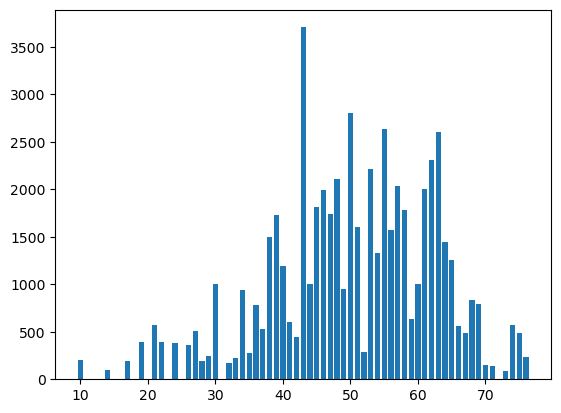

In [232]:
plt.bar(u,c)

In [146]:
len(peg_df['wt_w_context'][1])

241

In [121]:
np.unique(peg_df['Protospacer_30'])

array(['AAAAAACTCATGTTCAAGACAGAAGGGCCT', 'AAACAAAAGAAATGCAGGGGGATACGGCCA',
       'AAACCAGACCTCAGGCGGCTCATAGGGCAC', 'AAAGAAATGCAGGGGGATACGGCCAGGCAT',
       'AAAGCCCCCCTACTGCTCACCTGGAGGGCC', 'AAAGTTCCAAACAAAAGAAATGCAGGGGGA',
       'AACATCTCGAAGCGCTCACGCCCACGGATC', 'AACTGACCGTGCAAGTCACAGACTTGGCTG',
       'AAGCCCCCCTACTGCTCACCTGGAGGGCCA', 'AAGGAAATTTGCGTGTGGAGTATTTGGATG',
       'AAGGGACAGAAGATGACAGGGGCCAGGAGG', 'AAGGGTGAAATATTCTCCATCCAGTGGTTT',
       'AAGTCTCATGGAAGCCAGCCCCTCAGGGCA', 'AAGTGGAGAATGTCAGTCTGAGTCAGGCCC',
       'AAGTTCCAAACAAAAGAAATGCAGGGGGAT', 'AATCAACCCACAGCTGCACAGGGCAGGTCT',
       'AATCATCCATTGCTTGGGACGGCAAGGGGG', 'AATGGATCCACTCACAGTTTCCATAGGTCT',
       'ACAAGCAGTCACAGCACATGACGGAGGTTG', 'ACAGAAACACTTTTCGACATAGTGTGGTGG',
       'ACAGAAGATGACAGGGGCCAGGAGGGGGCT', 'ACAGCATCAAATCATCCATTGCTTGGGACG',
       'ACCAGGGCAGCTACGGTTTCCGTCTGGGCT', 'ACCATCATCACACTGGAAGACTCCAGGTCA',
       'ACCTGGAGTCTTCCAGTGTGATGATGGTGA', 'ACTACATGTGTAACAGTTCCTGCATGGGCG',
       'ACTGGAAACTTTCCACT

In [213]:
seqs = ['AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG(/ACAT)GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG',
        'TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACCCTCG(A/CC)GGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGACTAGC']

prime_design = pd.DataFrame(dict(zip(['SEQ'], [seqs])))
input_format = 'PrimeDesign'
peg_df = run(prime_design, input_format, chrom_dict)


In [214]:
peg_df

,mutation_idx,wt_w_context,alt_w_context,Variant_Type,REF,ALT,left_context,right_context,PAM_start,PAM_end,...,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
0,0,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGG...,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGAC...,INS,,ACAT,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG,GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG,42,45,...,GTCGAGCTACGATCGACTCG,CATGTCTCGA,10,GTCGATCG,8,CATGTCTCGAGTCGATCG,5,1,True,False
1,0,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGG...,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGAC...,INS,,ACAT,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG,GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG,42,45,...,GTCGAGCTACGATCGACTCG,CATGTCTCGA,10,GTCGATCGTA,10,CATGTCTCGAGTCGATCGTA,5,1,True,False
2,0,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGG...,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGAC...,INS,,ACAT,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG,GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG,42,45,...,GTCGAGCTACGATCGACTCG,CATGTCTCGA,10,GTCGATCGTAGCT,13,CATGTCTCGAGTCGATCGTAGCT,5,1,True,False
3,0,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGG...,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGAC...,INS,,ACAT,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG,GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG,42,45,...,GTCGAGCTACGATCGACTCG,CATGTCTCGA,10,GTCGATCGTAGCTCG,15,CATGTCTCGAGTCGATCGTAGCTCG,5,1,True,False
4,0,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGG...,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGAC...,INS,,ACAT,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG,GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG,42,45,...,GTCGAGCTACGATCGACTCG,GACGCCATGTCTCGA,15,GTCGATCG,8,GACGCCATGTCTCGAGTCGATCG,5,6,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,INDEL,A,CC,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,GGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGAC...,48,45,...,GCTCCCGAGCACCGGCCTCG,CGGCGCGCGCGTAGCGACCCTCGCC,25,GGCCGGTGCTCGGGA,15,CGGCGCGCGCGTAGCGACCCTCGCCGGCCGGTGCTCGGGA,0,23,True,True
88,1,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,INDEL,A,CC,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,GGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGAC...,48,45,...,GCTCCCGAGCACCGGCCTCG,CGGCGCGGCGCGCGCGTAGCGACCCTCGCC,30,GGCCGGTG,8,CGGCGCGGCGCGCGCGTAGCGACCCTCGCCGGCCGGTG,0,28,True,True
89,1,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,INDEL,A,CC,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,GGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGAC...,48,45,...,GCTCCCGAGCACCGGCCTCG,CGGCGCGGCGCGCGCGTAGCGACCCTCGCC,30,GGCCGGTGCT,10,CGGCGCGGCGCGCGCGTAGCGACCCTCGCCGGCCGGTGCT,0,28,True,True
90,1,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,INDEL,A,CC,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,GGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGAC...,48,45,...,GCTCCCGAGCACCGGCCTCG,CGGCGCGGCGCGCGCGTAGCGACCCTCGCC,30,GGCCGGTGCTCGG,13,CGGCGCGGCGCGCGCGTAGCGACCCTCGCCGGCCGGTGCTCGG,0,28,True,True


In [225]:
wt_seqs = ['AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG',
        'TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACCCTCGGGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGACTAGC']
alt_seqs = ['AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGAGGCCTCGAGGGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG',
        'TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGAGCCACGGGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGACTAGC']

wt_alt = pd.DataFrame(dict(zip(['WT', 'ALT'], [wt_seqs, alt_seqs])))
input_format = 'WT_ALT'
peg_df = run(wt_alt, input_format, chrom_dict, PAM='NNN')

# PEGG Score

- Update PEGG score to reflect the results of my dataset (include PAM/protospacer disrupting edits)

- Going to start by regenerating the RTT and PBS sequences from the p53 screen so that I have some sort of training data
- And then train a multiple linear regression or lasso regression thing to get the new PEGG score 
- And see how it behaves on the test set...
- I'll include the parameter of protospacer/PAM disruption

In [364]:
p53 = pd.read_csv('p53_combined_FINAL2.csv')

p53 = p53.rename(columns = {'HGVSp':'HGVSp_Short', 'Most frequent HGVSc':'HGVSc'})
p53['Variant_Classification']=None
p53['Consequence']=None
p53

,Unnamed: 0,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Strand,HGVSp_Short,num_occurences,codon,ref_aa,mut_aa,HGVSc,classification,Variant_Classification,Consequence
0,0,TP53,17,7578406,7578406,SNP,C,T,+,p.Arg175His,955.0,175.0,Arg,His,ENST00000269305.4:c.524G>A,missense,None,None
1,1,TP53,17,7577538,7577538,SNP,C,T,+,p.Arg248Gln,620.0,248.0,Arg,Gln,ENST00000269305.4:c.743G>A,missense,None,None
2,2,TP53,17,7577121,7577121,SNP,G,A,+,p.Arg273Cys,580.0,273.0,Arg,Cys,ENST00000269305.4:c.817C>T,missense,None,None
3,3,TP53,17,7577120,7577120,SNP,C,T,+,p.Arg273His,565.0,273.0,Arg,His,ENST00000269305.4:c.818G>A,missense,None,None
4,4,TP53,17,7577539,7577539,SNP,G,A,+,p.Arg248Trp,499.0,248.0,Arg,Trp,ENST00000269305.4:c.742C>T,missense,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,1257,TP53,17,7572987,7572989,ONP,ACC,TCC,+,NaN,NaN,374.0,Gly,Gly,NaN,neutral,None,None
1258,1258,TP53,17,7572975,7572977,ONP,GGA,ACT,+,NaN,NaN,378.0,Ser,Ser,NaN,neutral,None,None
1259,1259,TP53,17,7572963,7572965,ONP,TTT,CTT,+,NaN,NaN,382.0,Lys,Lys,NaN,neutral,None,None
1260,1260,TP53,17,7572951,7572953,ONP,CTT,TTT,+,NaN,NaN,386.0,Lys,Lys,NaN,neutral,None,None


In [365]:
input = p53
input_format = 'cBioPortal'
PBS_lengths = [10,13,15]
RTT_lengths = [10,15,20,25,30]
peg_df = run(input, input_format, chrom_dict, PBS_lengths=PBS_lengths, RTT_lengths=RTT_lengths, sensor_length=100, before_proto_context=20)
peg_df

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error
0,0,TP53,17,7578406,7578406,None,None,SNP,C,T,...,AGGCACTGCCCCCACCATGAGCGCTGCTCA,15,4,False,False,43.0,CATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGG...,CATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGG...,reverse-complement,No Error
1,0,TP53,17,7578406,7578406,None,None,SNP,C,T,...,AGGCACTGCCCCCACCATGAGCGCTGCTCAGAT,15,4,False,False,43.0,CATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGG...,CATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGG...,reverse-complement,No Error
2,0,TP53,17,7578406,7578406,None,None,SNP,C,T,...,AGGCACTGCCCCCACCATGAGCGCTGCTCAGATAG,15,4,False,False,43.0,CATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGG...,CATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGG...,reverse-complement,No Error
3,0,TP53,17,7578406,7578406,None,None,SNP,C,T,...,TTGTGAGGCACTGCCCCCACCATGAGCGCTGCTCA,15,9,False,False,43.0,CATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGG...,CATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGG...,reverse-complement,No Error
4,0,TP53,17,7578406,7578406,None,None,SNP,C,T,...,TTGTGAGGCACTGCCCCCACCATGAGCGCTGCTCAGAT,15,9,False,False,43.0,CATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGG...,CATGGCCATCTACAAGCAGTCACAGCACATGACGGAGGTTGTGAGG...,reverse-complement,No Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64378,1261,TP53,17,7572939,7572941,None,None,ONP,AGG,TGG,...,AATGTCAGTCTGAGTCTGGCCCTTCTGTCTTGAACATG,6,16,False,False,63.0,GGGGGTGGGAGGCTGTCAGTGGGGAACAAGAAGTGGAGAATGTCAG...,GGGGGTGGGAGGCTGTCAGTGGGGAACAAGAAGTGGAGAATGTCAG...,reverse-complement,No Error
64379,1261,TP53,17,7572939,7572941,None,None,ONP,AGG,TGG,...,AATGTCAGTCTGAGTCTGGCCCTTCTGTCTTGAACATGAG,6,16,False,False,63.0,GGGGGTGGGAGGCTGTCAGTGGGGAACAAGAAGTGGAGAATGTCAG...,GGGGGTGGGAGGCTGTCAGTGGGGAACAAGAAGTGGAGAATGTCAG...,reverse-complement,No Error
64380,1261,TP53,17,7572939,7572941,None,None,ONP,AGG,TGG,...,TGGAGAATGTCAGTCTGAGTCTGGCCCTTCTGTCTTGAAC,6,21,False,False,63.0,GGGGGTGGGAGGCTGTCAGTGGGGAACAAGAAGTGGAGAATGTCAG...,GGGGGTGGGAGGCTGTCAGTGGGGAACAAGAAGTGGAGAATGTCAG...,reverse-complement,No Error
64381,1261,TP53,17,7572939,7572941,None,None,ONP,AGG,TGG,...,TGGAGAATGTCAGTCTGAGTCTGGCCCTTCTGTCTTGAACATG,6,21,False,False,63.0,GGGGGTGGGAGGCTGTCAGTGGGGAACAAGAAGTGGAGAATGTCAG...,GGGGGTGGGAGGCTGTCAGTGGGGAACAAGAAGTGGAGAATGTCAG...,reverse-complement,No Error


In [370]:
old_proto = list(p53_old['protospacer'])
len(old_proto[0])

20

In [373]:
p53_old = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')

old_RTT_PBS = list(p53_old['PBS_RTT_5to3'])
old_proto = list(p53_old['protospacer'])
old_proto = [i[1:] for i in old_proto]
p53_old['proto_19'] = old_proto

In [375]:
peg_id = []
for i, val in peg_df.iterrows():

    rtt_pbs = val['RTT_PBS']
    proto = val['Protospacer'][1:]
    subset = p53_old[(p53_old['PBS_RTT_5to3']==rtt_pbs) & (p53_old['proto_19']==proto)]
    if len(subset)==0:
        peg_id.append(None)
    else:
        peg_id.append(list(subset['peg_id'])[0])
    


In [388]:
#now filtering the new pegRNAs based on this...
peg_df['peg_id']=peg_id

p53_pegs_new = peg_df.dropna(subset='peg_id')

In [422]:
p53_pegs_new

#also add in the PEGG score previously calculated
pegg_score_dict = dict(zip(list(p53_old['peg_id']), list(p53_old['PEGG_score'])))

p53_pegs_new['PEGG_score'] = [pegg_score_dict[i] for i in p53_pegs_new['peg_id']]

In [394]:
#importing the training data
#first read in information about the library

#p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')
#use the new dataframe instead...
import os
import scipy.stats

p53_filtered = p53_pegs_new
#and also information about the editing efficiency of each pegRNA in each time-point and replicate

samples = ['Plasmid-Library', 'D4-REP1', 'D4-REP2', 'D4-REP3',
'D16-REP1', 'D16-REP2', 'D16-REP3',
'D16-NUT-REP1', 'D16-NUT-REP2', 'D16-NUT-REP3',
'D25-REP1', 'D25-REP2', 'D25-REP3',
'D25-NUT-REP1', 'D25-NUT-REP2','D25-NUT-REP3',
'D34-REP1', 'D34-REP2', 'D34-REP3',
'D34-NUT-REP1', 'D34-NUT-REP2', 'D34-NUT-REP3']

crispresso = os.listdir("crispresso/compact_filtered_background_subtracted")

reorder = []
for i in samples:
    for k in crispresso:
        if i in k:
            df = pd.read_csv(f"crispresso/compact_filtered_background_subtracted/{k}")
            reorder.append(df)


cp_dict = dict(zip(samples, reorder))

In [436]:
# and calcualate correlation with pegRNA design parameters

factors = ['Proto_disrupted', 'PAM_disrupted', 'indel_size', 'PBS_GC_content', 'RTT_GC_content', 'RTT_length', 'PBS_length', 'Distance_to_nick', 'RHA_size', 'OnTarget_Azimuth_Score', 'PEGG_score']
col_label = ['sample'] + factors
z = np.zeros(len(samples[1:]))
cols = [samples[1:],z,z,z,z,z,z,z,z]
spear = pd.DataFrame(dict(zip(col_label,cols))).set_index('sample')
pearson = pd.DataFrame(dict(zip(col_label,cols))).set_index('sample')

#consider sensors with over 100 sensor reads
count_threshold = 100

for x in samples[1:]:
    df = cp_dict[x]

    #choose a particular variant type if desired
    var_types = ['SNP', 'INS', 'DEL', 'ONP'] #['SNP']

    chosen = list(p53_filtered[p53_filtered['Variant_Type'].isin(var_types)]['peg_id'])
    df = df[df['peg_id'].isin(chosen)]

    df = df[df['Reads_aligned_all_amplicons']>=count_threshold]

    p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]

    df = pd.merge(df, p53_subset, on='peg_id')

    #assert list(p53_subset['peg_id'])==list(df['peg_id']) #ensure indexing is correct

    for factor in factors:
        x1 = np.array(df[factor])
        y1 = np.array(df['corr_perc_backsub'])

        sr = scipy.stats.spearmanr(x1,y1).statistic
        pr = scipy.stats.pearsonr(x1,y1).statistic

        spear.loc[x, factor]=sr
        pearson.loc[x, factor]=pr

#and plot it
spear_T = spear.T
spear_T['Factor'] = list(spear_T.index)
melted_spear = pd.melt(spear_T, id_vars='Factor')

pearson_T = pearson.T
pearson_T['Factor'] = list(pearson_T.index)
melted_pear = pd.melt(pearson_T, id_vars='Factor')

In [ ]:
p53_pegs_new['Proto_disrupted'] = np.array(p53_pegs_new['Proto_disrupted'])+0
p53_pegs_new['PAM_disrupted'] = np.array(p53_pegs_new['PAM_disrupted'])+0

#also add in the PBS and RTT GC content
#and the size of the variant
pbs_gc = []
rtt_gc = []
var_size = []

for i, val in p53_pegs_new.iterrows():
    RTT = val['RTT']
    PBS = val['PBS']
    gc_count = RTT.count('G') + RTT.count('C')
    rtt_gc.append(gc_count/len(RTT))

    gc_count2 = PBS.count('G') + PBS.count('C')
    pbs_gc.append(gc_count2/len(PBS))

    ref = val['REF']
    alt = val['ALT']
    indelsize = abs(len(ref)-len(alt))
    var_size.append(indelsize)

p53_pegs_new['PBS_GC_content'] = pbs_gc
p53_pegs_new['RTT_GC_content'] = rtt_gc
p53_pegs_new['indel_size'] = var_size

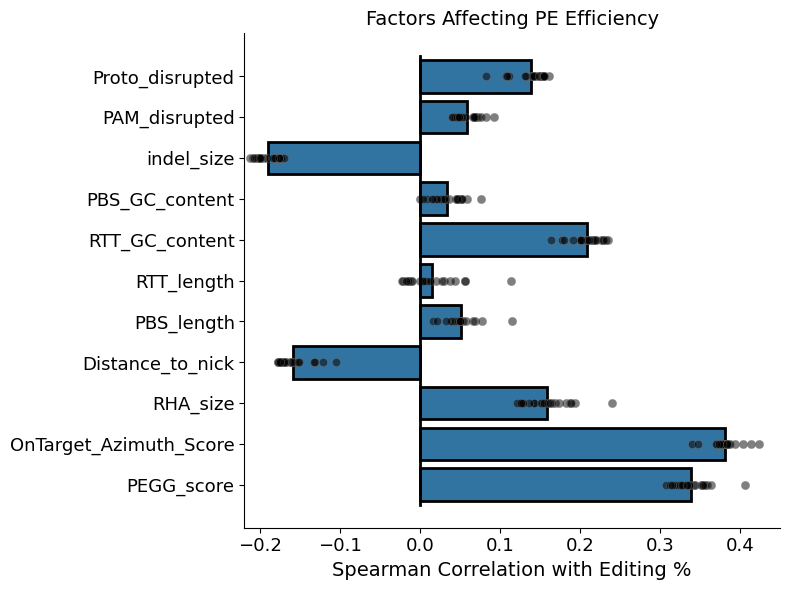

In [439]:
# and plotting
fig, ax = plt.subplots(figsize=(8,6))

g = sns.barplot(data=melted_spear, y='Factor', x='value', ax=ax, linewidth=2, edgecolor='black', palette=['tab:blue'], errorbar=None)
g = sns.scatterplot(data=melted_spear, y='Factor', x='value', ax=ax, color='black', edgecolor='grey', alpha=.5)
#each dot = a separate replicate

ax.plot([0,0], [0-.5,len(factors)-.5], linewidth=2, color='black')

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=13)

ax.set_title(f"Factors Affecting PE Efficiency", fontsize=14)

ax.set_xlabel("Spearman Correlation with Editing %", fontsize=14)
ax.set_ylabel("")

#labs = ['RTT Length', 'PBS Length', 'PBS GC Content', 'Distance to nick', 'Homology Overhang', 'MIT Specificity', "Doench '16 Score", 'PEGG Score']

ax.set_xlim(-.22, .45)
#ax.set_yticklabels(labs, rotation=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

## Creating a new PEGG Score

In [489]:
#training a new score

def peggscore2(df):
    
    df['Proto_disrupted'] = np.array(df['Proto_disrupted'])+0
    df['PAM_disrupted'] = np.array(df['PAM_disrupted'])+0

    #also add in the PBS and RTT GC content
    #and the size of the variant
    pbs_gc = []
    rtt_gc = []
    var_size = []

    for i, val in df.iterrows():
        RTT = val['RTT']
        PBS = val['PBS']
        gc_count = RTT.count('G') + RTT.count('C')
        rtt_gc.append(gc_count/len(RTT))

        gc_count2 = PBS.count('G') + PBS.count('C')
        pbs_gc.append(gc_count2/len(PBS))

        ref = val['REF']
        alt = val['ALT']
        indelsize = abs(len(ref)-len(alt))
        var_size.append(indelsize)

    df['PBS_GC_content'] = pbs_gc
    df['RTT_GC_content'] = rtt_gc
    df['indel_size'] = var_size

    factor_weights = {'Proto_disrupted':5, 
               'PAM_disrupted':3, 
               'indel_size':0, 
               'PBS_GC_content':0, 
               'RTT_GC_content':0, 
               'RTT_length':0, 
               'PBS_length':0, 
               'Distance_to_nick':-1, 
               'RHA_size':2, 
               'OnTarget_Azimuth_Score':.2}


    fw = [ 2.89996998,  1.58522483, -0.51088186,  8.78468344,  6.30826281,
       -0.33821302,  0.1058144 ,  0.30468214,  0.36783961,  0.14474713]

    factor_weights = dict(zip(factor_weights.keys(), fw))

    factor_lists = []
    for i in factor_weights.keys():
        weight = factor_weights[i]
        factor_lists.append(weight*np.asarray(df[i]))

    pegg2_score = np.zeros(len(factor_lists[0]))
    for i in factor_lists:
        pegg2_score+=i
    
    df['PEGG2_Score']=pegg2_score

    return df



In [571]:
from sklearn import linear_model

x = 'D16-REP1'
df = cp_dict[x]

p53_filtered = peggscore2(p53_pegs_new)

#choose a particular variant type if desired
var_types = ['SNP', 'INS', 'DEL', 'ONP'] #['SNP']

chosen = list(p53_filtered[p53_filtered['Variant_Type'].isin(var_types)]['peg_id'])
df = df[df['peg_id'].isin(chosen)]

count_threshold=50
df = df[df['Reads_aligned_all_amplicons']>=count_threshold]

p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]

df = pd.merge(df, p53_subset, on='peg_id')


regr = linear_model.LinearRegression()

X = df[['Proto_disrupted', 'PAM_disrupted', 'indel_size', 'PBS_GC_content', 'RTT_GC_content', 'RTT_length', 'PBS_length', 'Distance_to_nick', 'RHA_size', 'OnTarget_Azimuth_Score']]

y = df['corr_perc_backsub']
regr.fit(X, y)

LinearRegression()

In [572]:
regr.coef_

array([ 2.89996998,  1.58522483, -0.51088186,  8.78468344,  6.30826281,
       -0.33821302,  0.1058144 ,  0.30468214,  0.36783961,  0.14474713])

In [573]:
logregr = linear_model.ElasticNet()

X = df[['Proto_disrupted', 'PAM_disrupted', 'indel_size', 'PBS_GC_content', 'RTT_GC_content', 'RTT_length', 'PBS_length', 'Distance_to_nick', 'RHA_size', 'OnTarget_Azimuth_Score']]

y = df['corr_perc_backsub']
logregr.fit(X, y)

ElasticNet()

In [574]:
logregr.coef_

array([ 0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.14932316,  0.04236468,  0.14143966])

In [575]:
ridge_model = logregr.predict(X)

In [576]:
p53_filtered = peggscore2(p53_pegs_new)
X=p53_filtered[['Proto_disrupted', 'PAM_disrupted', 'indel_size', 'PBS_GC_content', 'RTT_GC_content', 'RTT_length', 'PBS_length', 'Distance_to_nick', 'RHA_size', 'OnTarget_Azimuth_Score']]
ridge_model = logregr.predict(X)
p53_filtered['Ridge_regr'] = ridge_model

factors = ['Proto_disrupted', 'PAM_disrupted', 'indel_size', 'PBS_GC_content', 'RTT_GC_content', 'RTT_length', 'PBS_length', 'Distance_to_nick', 'RHA_size', 'OnTarget_Azimuth_Score', 'PEGG_score', 'PEGG2_Score', 'Ridge_regr']
col_label = ['sample'] + factors
z = np.zeros(len(samples[1:]))
cols = [samples[1:],z,z,z,z,z,z,z,z]
spear = pd.DataFrame(dict(zip(col_label,cols))).set_index('sample')
pearson = pd.DataFrame(dict(zip(col_label,cols))).set_index('sample')

#consider sensors with over 100 sensor reads
count_threshold = 100

for x in samples[1:]:
    df = cp_dict[x]

    #choose a particular variant type if desired
    var_types = ['SNP', 'INS', 'DEL', 'ONP'] #['SNP']

    chosen = list(p53_filtered[p53_filtered['Variant_Type'].isin(var_types)]['peg_id'])
    df = df[df['peg_id'].isin(chosen)]

    df = df[df['Reads_aligned_all_amplicons']>=count_threshold]

    p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]

    df = pd.merge(df, p53_subset, on='peg_id')

    #assert list(p53_subset['peg_id'])==list(df['peg_id']) #ensure indexing is correct

    for factor in factors:
        x1 = np.array(df[factor])
        y1 = np.array(df['corr_perc_backsub'])

        sr = scipy.stats.spearmanr(x1,y1).statistic
        pr = scipy.stats.pearsonr(x1,y1).statistic

        spear.loc[x, factor]=sr
        pearson.loc[x, factor]=pr

#and plot it
spear_T = spear.T
spear_T['Factor'] = list(spear_T.index)
melted_spear = pd.melt(spear_T, id_vars='Factor')

pearson_T = pearson.T
pearson_T['Factor'] = list(pearson_T.index)
melted_pear = pd.melt(pearson_T, id_vars='Factor')

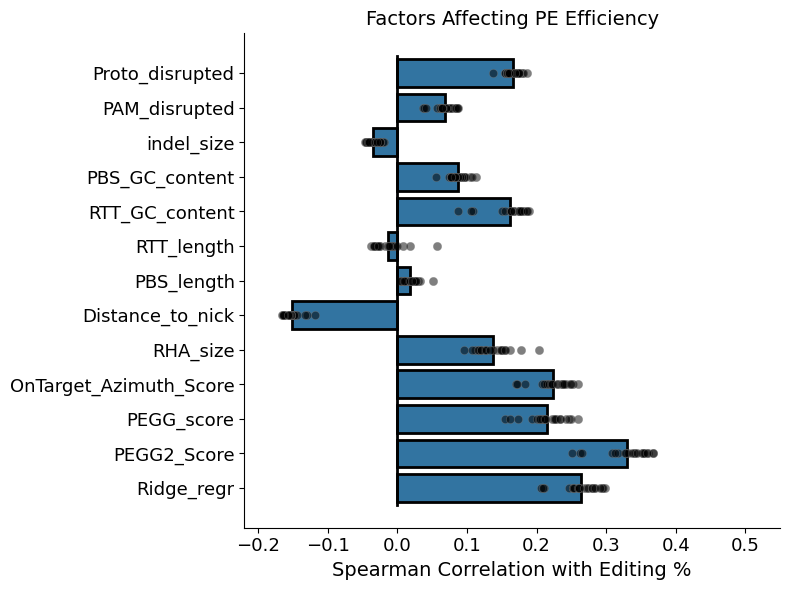

In [580]:
# and plotting
fig, ax = plt.subplots(figsize=(8,6))

g = sns.barplot(data=melted_pear, y='Factor', x='value', ax=ax, linewidth=2, edgecolor='black', palette=['tab:blue'], errorbar=None)
g = sns.scatterplot(data=melted_pear, y='Factor', x='value', ax=ax, color='black', edgecolor='grey', alpha=.5)
#each dot = a separate replicate

ax.plot([0,0], [0-.5,len(factors)-.5], linewidth=2, color='black')

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=13)

ax.set_title(f"Factors Affecting PE Efficiency", fontsize=14)

ax.set_xlabel("Spearman Correlation with Editing %", fontsize=14)
ax.set_ylabel("")

#labs = ['RTT Length', 'PBS Length', 'PBS GC Content', 'Distance to nick', 'Homology Overhang', 'MIT Specificity', "Doench '16 Score", 'PEGG Score']

ax.set_xlim(-.22, .55)
#ax.set_yticklabels(labs, rotation=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

In [579]:
melted_pear[melted_pear['Factor']=='OnTarget_Azimuth_Score']

,Factor,sample,value
9,OnTarget_Azimuth_Score,D4-REP1,0.183388
22,OnTarget_Azimuth_Score,D4-REP2,0.171074
35,OnTarget_Azimuth_Score,D4-REP3,0.171254
48,OnTarget_Azimuth_Score,D16-REP1,0.207430
61,OnTarget_Azimuth_Score,D16-REP2,0.214895
74,OnTarget_Azimuth_Score,D16-REP3,0.215016
87,OnTarget_Azimuth_Score,D16-NUT-REP1,0.210615
100,OnTarget_Azimuth_Score,D16-NUT-REP2,0.217371
113,OnTarget_Azimuth_Score,D16-NUT-REP3,0.220664
126,OnTarget_Azimuth_Score,D25-REP1,0.221888


In [581]:
x = 'D16-REP1'
df = cp_dict[x]

p53_filtered = peggscore2(p53_pegs_new)

#choose a particular variant type if desired
var_types = ['SNP', 'INS', 'DEL', 'ONP'] #['SNP']

chosen = list(p53_filtered[p53_filtered['Variant_Type'].isin(var_types)]['peg_id'])
df = df[df['peg_id'].isin(chosen)]

count_threshold=50
df = df[df['Reads_aligned_all_amplicons']>=count_threshold]

p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]

df = pd.merge(df, p53_subset, on='peg_id')



In [629]:
from sklearn.ensemble import RandomForestRegressor # for building the model

def model_training(b):
    #converting PAM sequences and variant types to integers for training
    PAM_dict = {"AGG":0, 'GGG':1, 'CGG':2, 'TGG':3}
    num_PAM = [PAM_dict[k] for k in b['PAM']]
    b['num_PAM'] = num_PAM

    #var_dict = {"SNP":0, 'INS':1, 'DEL':2, 'ONP':3}
    #num_var = [var_dict[k] for k in b['Variant_Type']]
    #b['var_type'] = num_var
    b = b[b['Variant_Type']!='ONP']
    #adding in correct percentage
    b['corr_perc'] = b['corr_perc_backsub']

    #train, test splitting; ensuring same variant isn't in train and test
    uniq_DNA = np.unique(b['HGVSp_Short'])
    perc_train = .7
    num_train = int(perc_train*len(uniq_DNA))

    train_set = list(np.random.choice(uniq_DNA, size=num_train, replace=False))

    train = b[b['HGVSp_Short'].isin(train_set)]
    test =b[~b['HGVSp_Short'].isin(train_set)]

    factors = ['Proto_disrupted', 'PAM_disrupted', 'indel_size', 'PBS_GC_content', 'RTT_GC_content', 'RTT_length', 'PBS_length', 'Distance_to_nick', 'RHA_size', 'OnTarget_Azimuth_Score'] #, 'PEGG_score', 'PEGG2_Score', 'Ridge_regr']

    X_train = np.array(train[factors])
    Y_train = np.array(train[["corr_perc"]])

    X_test = np.array(test[factors])
    Y_test = np.array(test[["corr_perc"]])

    # Initializing the Random Forest Regression model with 100 decision trees
    model = RandomForestRegressor(n_estimators = 100, random_state = 0)

    # Fitting the Random Forest Regression model to the data
    model.fit(X_train, Y_train)

    return model, X_train, Y_train, X_test, Y_test

In [630]:
model, X_train, Y_train, X_test, Y_test = model_training(df)

SignificanceResult(statistic=0.8409915360004937, pvalue=0.0)


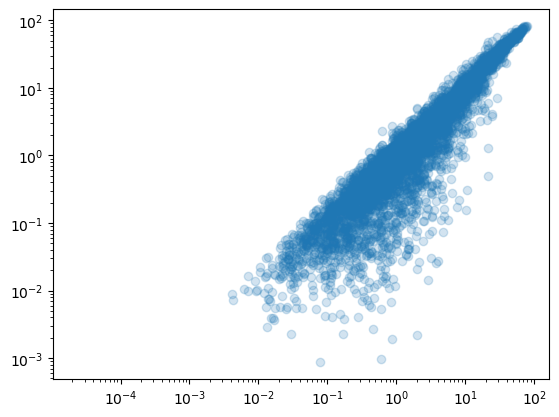

In [631]:
y_train = model.predict(X_train)

plt.scatter(y_train, Y_train, alpha=.2)
print(scipy.stats.spearmanr(y_train, Y_train))
plt.yscale("log")
plt.xscale("log")

SignificanceResult(statistic=0.6304209972485361, pvalue=0.0)


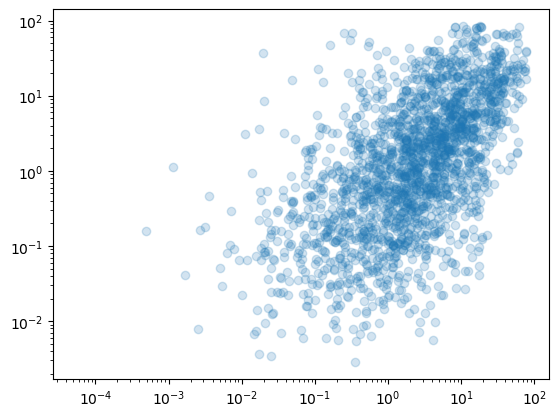

In [632]:
y_test = model.predict(X_test)

print(scipy.stats.spearmanr(y_test, Y_test))
plt.scatter(y_test, Y_test, alpha=.2)
plt.yscale("log")
plt.xscale("log")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Proto_disrupted'),
  Text(1, 0, 'PAM_disrupted'),
  Text(2, 0, 'indel_size'),
  Text(3, 0, 'PBS_GC_content'),
  Text(4, 0, 'RTT_GC_content'),
  Text(5, 0, 'RTT_length'),
  Text(6, 0, 'PBS_length'),
  Text(7, 0, 'Distance_to_nick'),
  Text(8, 0, 'RHA_size'),
  Text(9, 0, 'OnTarget_Azimuth_Score')])

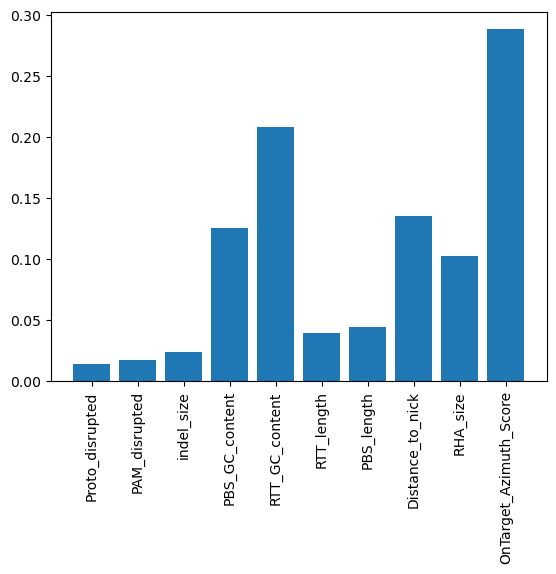

In [633]:
importance = model.feature_importances_

factors = ['Proto_disrupted', 'PAM_disrupted', 'indel_size', 'PBS_GC_content', 'RTT_GC_content', 'RTT_length', 'PBS_length', 'Distance_to_nick', 'RHA_size', 'OnTarget_Azimuth_Score'] #, 'PEGG_score', 'PEGG2_Score', 'Ridge_regr']

#factors = ['PBS_GC_content', 'RTT_GC_content', 'Distance_to_nick', 'RHA_size', 'OnTarget_Azimuth_Score'] #, 'PEGG_score', 'PEGG2_Score', 'Ridge_regr']

plt.bar(factors, importance)
plt.xticks(rotation=90)

# pegRNA visualization

- Make an option for non-sensor visualization?
    - Probably fine to avoid this for now...

In [233]:
df_w_sensor

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted,sensor_wt,sensor_alt,sensor_error,sensor_orientation
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,8,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,10,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement
2,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,13,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCA,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement
3,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,15,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA,19,5,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement
4,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,8,TTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,10,False,False,GGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCG...,GGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG...,No Error,reverse-complement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58127,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,15,GGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGGTG,1,24,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement
58128,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,8,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCT,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement
58129,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,10,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGC,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement
58130,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,13,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGG,1,29,True,True,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGTGTAGGAGCT...,CAGGGGCCAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTG...,No Error,reverse-complement


In [234]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.patches import Polygon

In [235]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.patches import Polygon
def split(word):
    """Simple function for splitting string into component characters"""
    return [char for char in word]

In [248]:
i=0
sensor = df_w_sensor.iloc[i]['sensor_wt']
sensor_comp = str(Bio.Seq.Seq(sensor).complement())

proto = str(Bio.Seq.Seq(df_w_sensor.iloc[i]['Protospacer']).reverse_complement())

sensor.find(proto[:19])

35

In [345]:
df_w_sensor = peg_df

Text(0.5, 1.0, 'RTT length: 25 nt, PBS length: 13 nt | DEL: G>')

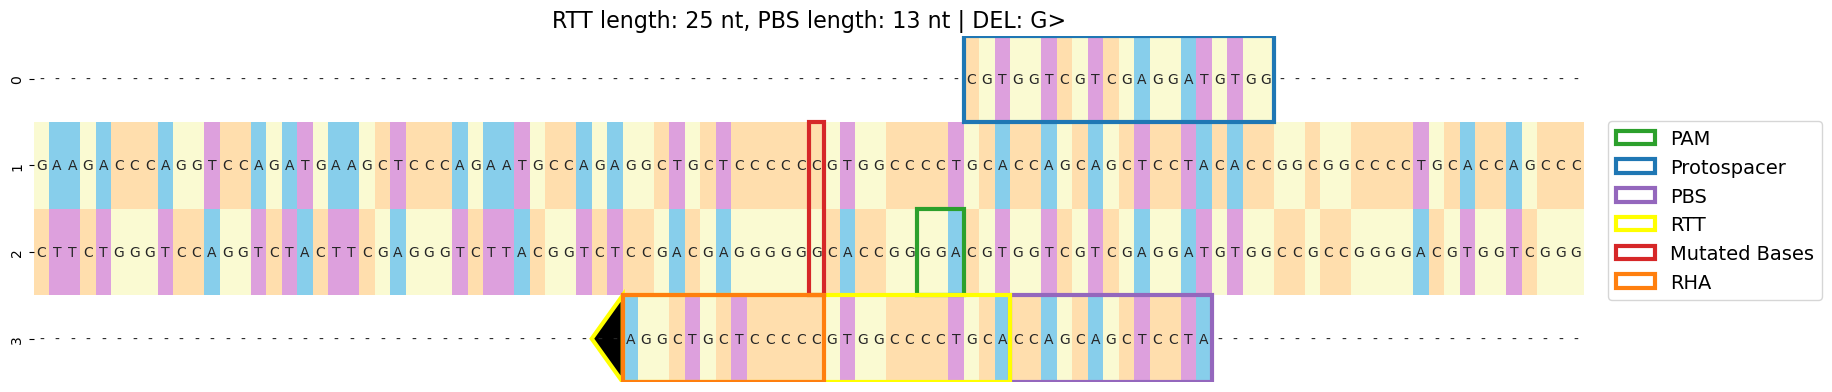

In [657]:
i=17986+2000

#need to make this dependent on the orientation of the sensor!!!

PAM = df_w_sensor.iloc[i]['PAM']
PAM_len = len(PAM)

sensor = df_w_sensor.iloc[i]['sensor_wt']
sensor_comp = str(Bio.Seq.Seq(sensor).complement())
split_test = split(sensor)
split_test_comp = split(str(sensor_comp))

#protospacer
proto = df_w_sensor.iloc[i]['Protospacer']
proto_start = sensor_comp.find(proto[::-1][:19])
proto_left = ['-']*(proto_start)
proto_right = ['-']*(len(sensor)-proto_start-len(proto))
split_p = split(proto[::-1])
split_proto = proto_left + split_p + proto_right

#RTT_PBS
RTT_len = df_w_sensor.iloc[i]['RTT_length']
PBS_len =  df_w_sensor.iloc[i]['PBS_length']
RTT_PBS = df_w_sensor.iloc[i]['RTT_PBS']
RTT_PBS_end = proto_start+3+PBS_len
RTT_PBS_start = RTT_PBS_end - len(RTT_PBS)
left = ['-']*RTT_PBS_start
right = ['-']*(len(sensor) - RTT_PBS_end)
split_RTTPBS = split(RTT_PBS)
split_RTT_PBS = left + split_RTTPBS + right

#translation for coloring
dict_bases = {'T':0, 'A':1, 'C':2, 'G':3, '-':4, 'X':5}
num_translation = [dict_bases[i] for i in split_test]
num_translation_c = [dict_bases[i] for i in split_test_comp]
num_translation_proto = [dict_bases[i] for i in split_proto]
num_translation_RTT = [dict_bases[i] for i in split_RTT_PBS]

text_df = [split_proto, split_test, split_test_comp, split_RTT_PBS]
dataFrame = [num_translation_proto, num_translation, num_translation_c,num_translation_RTT]

fig_height = 4.5
fig = plt.figure(figsize=(20,fig_height))
myColors = ('plum', 'skyblue', 'navajowhite', 'lightgoldenrodyellow', 'white')
#if var_type=='DEL':
#    myColors = ('plum', 'skyblue', 'navajowhite', 'lightgoldenrodyellow', 'white', 'black')

cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

ax = sns.heatmap(dataFrame, annot=text_df, fmt="", linewidth=0, cmap=cmap, cbar=False,linewidths=0, linecolor='lightgray', xticklabels=False)

ax.add_patch(patches.Rectangle((proto_start-PAM_len, 2), 3, 1, fill=False, edgecolor='tab:green', lw=3, label='PAM')) #protospacer loca)) #protospacer location

#protospacer
ax.add_patch(patches.Rectangle((proto_start, 0), len(proto), 1, fill=False, edgecolor='tab:blue', lw=3, label='Protospacer')) #protospacer location

#PBS
ax.add_patch(patches.Rectangle((proto_start+3, 3), PBS_len, 1, fill=False, edgecolor='tab:purple', lw=3, label='PBS')) #protospacer location

#RTT
ax.add_patch(patches.Rectangle((proto_start+3-RTT_len, 3), RTT_len, 1, fill=False, edgecolor='yellow', lw=3, label='RTT')) #protospacer location
ax.add_patch(Polygon([(proto_start+3-RTT_len, 3), (proto_start+3-RTT_len-2, 3.5), (proto_start+3-RTT_len, 4)],facecolor='black',edgecolor='yellow', lw=3))

#finally, mark the location of the sequence to be mutated
RHA = df_w_sensor.iloc[i]['RHA_size']
vt = df_w_sensor.iloc[i]['Variant_Type']
mut_start = proto_start+3-RTT_len + RHA

if vt == 'INS':
    #mut_size = 2
    mut_size = len(df_w_sensor.iloc[i]['ALT'])

    ax.add_patch(patches.Rectangle((mut_start+mut_size, 1), 0, 2, fill=False, edgecolor='tab:red', lw=3, label='Mutated Bases')) #protospacer location

elif vt=='DEL':
    mut_size = len(df_w_sensor.iloc[i]['REF'])

    ax.add_patch(patches.Rectangle((mut_start-mut_size, 1), mut_size, 2, fill=False, edgecolor='tab:red', lw=3, label='Mutated Bases')) #protospacer location


else:
    mut_size = len(df_w_sensor.iloc[i]['REF'])

    ax.add_patch(patches.Rectangle((mut_start, 1), mut_size, 2, fill=False, edgecolor='tab:red', lw=3, label='RTT')) #protospacer location

#also label the RHA

ax.add_patch(patches.Rectangle((proto_start+3-RTT_len, 3), RHA, 1, fill=False, edgecolor='tab:orange', lw=3, label='RHA')) #protospacer location

ax.legend(bbox_to_anchor=(1.16,.78), fontsize=14)

ref_allele = df_w_sensor.iloc[i]['REF']
mut_allele = df_w_sensor.iloc[i]['ALT']

ax.set_title('RTT length: '+str(RTT_len)+ ' nt, PBS length: ' + str(PBS_len)+' nt | ' + vt + ': '+ref_allele + '>' + mut_allele, fontsize=16)


In [6]:
peg_df

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
2,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCA,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
3,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
4,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,TTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,10,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58431,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,GGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGGTG,1,24,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error
58432,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCT,1,29,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error
58433,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGC,1,29,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error
58434,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGG,1,29,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error


In [107]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.patches import Polygon
def split(word):
    """Simple function for splitting string into component characters"""
    return [char for char in word]

def sensor_viz(df_w_sensor, i):    
    sensor_orientation = df_w_sensor.iloc[i]['sensor_orientation']

    PAM = df_w_sensor.iloc[i]['PAM']
    PAM_len = len(PAM)

    sensor = df_w_sensor.iloc[i]['sensor_wt']
    sensor_comp = str(Bio.Seq.Seq(sensor).complement())
    split_test = split(sensor)
    split_test_comp = split(str(sensor_comp))

    if sensor_orientation == 'reverse-complement':
        #protospacer
        proto = df_w_sensor.iloc[i]['Protospacer']
        proto_start = sensor_comp.find(proto[::-1][:19])
        proto_left = ['-']*(proto_start)
        proto_right = ['-']*(len(sensor)-proto_start-len(proto))
        split_p = split(proto[::-1])
        split_proto = proto_left + split_p + proto_right

        #RTT_PBS
        RTT_len = df_w_sensor.iloc[i]['RTT_length']
        PBS_len =  df_w_sensor.iloc[i]['PBS_length']
        RTT_PBS = df_w_sensor.iloc[i]['RTT_PBS']
        RTT_PBS_end = proto_start+3+PBS_len
        RTT_PBS_start = RTT_PBS_end - len(RTT_PBS)
        left = ['-']*RTT_PBS_start
        right = ['-']*(len(sensor) - RTT_PBS_end)
        split_RTTPBS = split(RTT_PBS)
        split_RTT_PBS = left + split_RTTPBS + right

        #translation for coloring
        dict_bases = {'T':0, 'A':1, 'C':2, 'G':3, '-':4, 'X':5}
        num_translation = [dict_bases[i] for i in split_test]
        num_translation_c = [dict_bases[i] for i in split_test_comp]
        num_translation_proto = [dict_bases[i] for i in split_proto]
        num_translation_RTT = [dict_bases[i] for i in split_RTT_PBS]

        text_df = [split_proto, split_test, split_test_comp, split_RTT_PBS]
        dataFrame = [num_translation_proto, num_translation, num_translation_c,num_translation_RTT]

        fig_height = 4.5
        fig = plt.figure(figsize=(20,fig_height))
        myColors = ('plum', 'skyblue', 'navajowhite', 'lightgoldenrodyellow', 'white')
        #if var_type=='DEL':
        #    myColors = ('plum', 'skyblue', 'navajowhite', 'lightgoldenrodyellow', 'white', 'black')

        cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

        ax = sns.heatmap(dataFrame, annot=text_df, fmt="", linewidth=0, cmap=cmap, cbar=False,linewidths=0, linecolor='lightgray', xticklabels=False)

        ax.add_patch(patches.Rectangle((proto_start-PAM_len, 2), PAM_len, 1, fill=False, edgecolor='tab:green', lw=3, label='PAM')) #protospacer loca)) #protospacer location

        #protospacer
        ax.add_patch(patches.Rectangle((proto_start, 0), len(proto), 1, fill=False, edgecolor='tab:blue', lw=3, label='Protospacer')) #protospacer location

        #PBS
        ax.add_patch(patches.Rectangle((proto_start+3, 3), PBS_len, 1, fill=False, edgecolor='tab:purple', lw=3, label='PBS')) #protospacer location

        #RTT
        ax.add_patch(patches.Rectangle((proto_start+3-RTT_len, 3), RTT_len, 1, fill=False, edgecolor='yellow', lw=3, label='RTT')) #protospacer location
        ax.add_patch(Polygon([(proto_start+3-RTT_len, 3), (proto_start+3-RTT_len-2, 3.5), (proto_start+3-RTT_len, 4)],facecolor='black',edgecolor='yellow', lw=3))

        #finally, mark the location of the sequence to be mutated
        RHA = df_w_sensor.iloc[i]['RHA_size']
        vt = df_w_sensor.iloc[i]['Variant_Type']
        mut_start = proto_start+3-RTT_len + RHA

        if vt == 'INS':
            #mut_size = 2
            mut_size = len(df_w_sensor.iloc[i]['ALT'])

            ax.add_patch(patches.Rectangle((mut_start+mut_size, 1), 0, 2, fill=False, edgecolor='tab:red', lw=3, label='Mutated Bases')) #protospacer location

        elif vt=='DEL':
            mut_size = len(df_w_sensor.iloc[i]['REF'])

            ax.add_patch(patches.Rectangle((mut_start-mut_size, 1), mut_size, 2, fill=False, edgecolor='tab:red', lw=3, label='Mutated Bases')) #protospacer location


        else:
            mut_size = len(df_w_sensor.iloc[i]['REF'])

            ax.add_patch(patches.Rectangle((mut_start, 1), mut_size, 2, fill=False, edgecolor='tab:red', lw=3, label='RTT')) #protospacer location

        #also label the RHA

        ax.add_patch(patches.Rectangle((proto_start+3-RTT_len, 3), RHA, 1, fill=False, edgecolor='tab:orange', lw=3, label='RHA')) #protospacer location

    elif sensor_orientation == 'forward':

        #protospacer
        proto = df_w_sensor.iloc[i]['Protospacer']
        proto_start = sensor.find(proto[1:])-1 #account for G+19 or G+20
        proto_left = ['-']*(proto_start)
        proto_right = ['-']*(len(sensor)-proto_start-len(proto))
        split_p = split(proto)
        split_proto = proto_left + split_p + proto_right

        #RTT_PBS
        RTT_len = df_w_sensor.iloc[i]['RTT_length']
        PBS_len =  df_w_sensor.iloc[i]['PBS_length']
        RTT_PBS = str(df_w_sensor.iloc[i]['RTT_PBS'])[::-1] #[::-1] #reverse it for 3' to

        RTT_PBS_end = proto_start+3+PBS_len
        #RTT_PBS_start = RTT_PBS_end - len(RTT_PBS)

        RTT_PBS_start = proto_start + len(proto) -3 - PBS_len
        RTT_PBS_end = proto_start + len(proto) -3 + RTT_len

        left = ['-']*RTT_PBS_start
        right = ['-']*(len(sensor) - RTT_PBS_end)
        split_RTTPBS = split(RTT_PBS)
        split_RTT_PBS = left + split_RTTPBS + right
        print(len(split_RTT_PBS))

        #translation for coloring
        dict_bases = {'T':0, 'A':1, 'C':2, 'G':3, '-':4, 'X':5}
        num_translation = [dict_bases[i] for i in split_test]
        num_translation_c = [dict_bases[i] for i in split_test_comp]
        num_translation_proto = [dict_bases[i] for i in split_proto]
        num_translation_RTT = [dict_bases[i] for i in split_RTT_PBS]

        text_df = [split_RTT_PBS, split_test, split_test_comp, split_proto]
        dataFrame = [num_translation_RTT, num_translation, num_translation_c, num_translation_proto,]

        fig_height = 4.5
        fig = plt.figure(figsize=(20,fig_height))
        myColors = ('plum', 'skyblue', 'navajowhite', 'lightgoldenrodyellow', 'white')
        #if var_type=='DEL':
        #    myColors = ('plum', 'skyblue', 'navajowhite', 'lightgoldenrodyellow', 'white', 'black')

        cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

        ax = sns.heatmap(dataFrame, annot=text_df, fmt="", linewidth=0, cmap=cmap, cbar=False,linewidths=0, linecolor='lightgray', xticklabels=False)

        #PAM
        ax.add_patch(patches.Rectangle((proto_start+len(proto), 1), PAM_len, 1, fill=False, edgecolor='tab:green', lw=3, label='PAM')) #protospacer loca)) #protospacer location

        #protospacer
        ax.add_patch(patches.Rectangle((proto_start, 3), len(proto), 1, fill=False, edgecolor='tab:blue', lw=3, label='Protospacer')) #protospacer location

        #PBS
        ax.add_patch(patches.Rectangle((RTT_PBS_start, 0), PBS_len, 1, fill=False, edgecolor='tab:purple', lw=3, label='PBS')) #protospacer location

        #RTT
        ax.add_patch(patches.Rectangle((RTT_PBS_start + PBS_len, 0), RTT_len, 1, fill=False, edgecolor='yellow', lw=3, label='RTT')) #protospacer location
        ax.add_patch(Polygon([(RTT_PBS_start + PBS_len+RTT_len, 0), (RTT_PBS_start + PBS_len+RTT_len+2, 0.5), (RTT_PBS_start + PBS_len+RTT_len, 1)],facecolor='black',edgecolor='yellow', lw=3))

        #finally, mark the location of the sequence to be mutated
        RHA = df_w_sensor.iloc[i]['RHA_size']
        vt = df_w_sensor.iloc[i]['Variant_Type']
        mut_start = RTT_PBS_start + RTT_len + PBS_len - RHA -1

        if vt == 'INS':
            #mut_size = 2
            mut_size = len(df_w_sensor.iloc[i]['ALT'])

            ax.add_patch(patches.Rectangle((mut_start+mut_size, 1), 0, 2, fill=False, edgecolor='tab:red', lw=3, label='Mutated Bases')) #protospacer location

        elif vt=='DEL':
            mut_size = len(df_w_sensor.iloc[i]['REF'])

            ax.add_patch(patches.Rectangle((mut_start-mut_size, 1), mut_size, 2, fill=False, edgecolor='tab:red', lw=3, label='Mutated Bases')) #protospacer location


        else:
            mut_size = len(df_w_sensor.iloc[i]['REF'])

            ax.add_patch(patches.Rectangle((mut_start-mut_size+1, 1), mut_size, 2, fill=False, edgecolor='tab:red', lw=3, label='Mutated Bases')) #protospacer location

        #also label the RHA

        ax.add_patch(patches.Rectangle((mut_start+1, 0), RHA, 1, fill=False, edgecolor='tab:orange', lw=3, label='RHA')) #protospacer location




    ax.legend(bbox_to_anchor=(1.16,.78), fontsize=14)

    ref_allele = df_w_sensor.iloc[i]['REF']
    mut_allele = df_w_sensor.iloc[i]['ALT']

    ax.set_title('RTT length: '+str(RTT_len)+ ' nt, PBS length: ' + str(PBS_len)+' nt | ' + vt + ': '+ref_allele + '>' + mut_allele, fontsize=16)


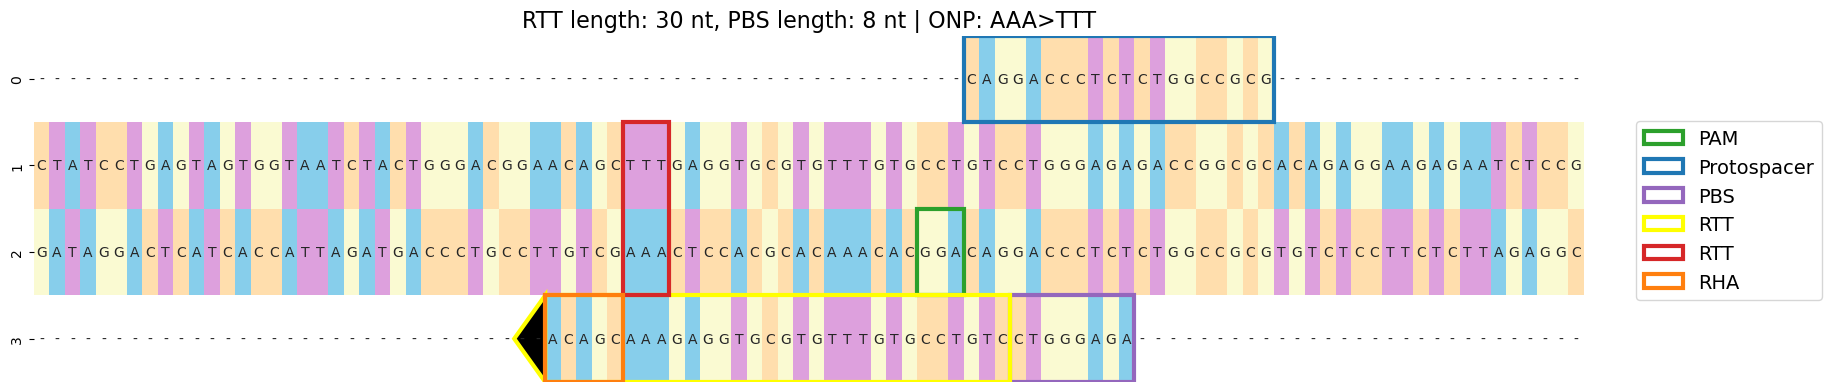

In [111]:
sensor_viz(peg_df, 1128)

In [54]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.patches import Polygon

def split(word):
    """Simple function for splitting string into component characters"""
    return [char for char in word]

def sensor_viz_base(df_w_sensor, i):    
    sensor_orientation = df_w_sensor.iloc[i]['sensor_orientation']

    PAM = df_w_sensor.iloc[i]['PAM']
    PAM_len = len(PAM)

    sensor = df_w_sensor.iloc[i]['sensor_wt']
    sensor_comp = str(Bio.Seq.Seq(sensor).complement())
    split_test = split(sensor)
    split_test_comp = split(str(sensor_comp))

    proto_loc = df_w_sensor.iloc[i]['Protospacer_Location']

    if sensor_orientation == 'reverse-complement':
        #protospacer
        proto = df_w_sensor.iloc[i]['Protospacer']
        proto_start = sensor_comp.find(proto[::-1][:19])
        proto_left = ['-']*(proto_start)
        proto_right = ['-']*(len(sensor)-proto_start-len(proto))
        split_p = split(proto[::-1])
        split_proto = proto_left + split_p + proto_right

        #translation for coloring
        dict_bases = {'T':0, 'A':1, 'C':2, 'G':3, '-':4, 'X':5}
        num_translation = [dict_bases[i] for i in split_test]
        num_translation_c = [dict_bases[i] for i in split_test_comp]
        num_translation_proto = [dict_bases[i] for i in split_proto]

        text_df = [split_proto, split_test, split_test_comp]
        dataFrame = [num_translation_proto, num_translation, num_translation_c]

        fig_height = 4.5
        fig = plt.figure(figsize=(20,fig_height))
        myColors = ('plum', 'skyblue', 'navajowhite', 'lightgoldenrodyellow', 'white')
        #if var_type=='DEL':
        #    myColors = ('plum', 'skyblue', 'navajowhite', 'lightgoldenrodyellow', 'white', 'black')

        cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

        ax = sns.heatmap(dataFrame, annot=text_df, fmt="", linewidth=0, cmap=cmap, cbar=False,linewidths=0, linecolor='lightgray', xticklabels=False)

        ax.add_patch(patches.Rectangle((proto_start-PAM_len, 2), PAM_len, 1, fill=False, edgecolor='tab:green', lw=3, label='PAM')) #protospacer loca)) #protospacer location

        #protospacer
        ax.add_patch(patches.Rectangle((proto_start, 0), len(proto), 1, fill=False, edgecolor='tab:blue', lw=3, label='Protospacer')) #protospacer location


    elif sensor_orientation == 'forward':

        #protospacer
        proto = df_w_sensor.iloc[i]['Protospacer']
        proto_start = sensor.find(proto[1:])-1 #account for G+19 or G+20
        proto_left = ['-']*(proto_start)
        proto_right = ['-']*(len(sensor)-proto_start-len(proto))
        split_p = split(proto)
        split_proto = proto_left + split_p + proto_right

        
        #translation for coloring
        dict_bases = {'T':0, 'A':1, 'C':2, 'G':3, '-':4, 'X':5}
        num_translation = [dict_bases[i] for i in split_test]
        num_translation_c = [dict_bases[i] for i in split_test_comp]
        num_translation_proto = [dict_bases[i] for i in split_proto]

        text_df = [split_test, split_test_comp, split_proto]
        dataFrame = [num_translation, num_translation_c, num_translation_proto]

        fig_height = 4.5
        fig = plt.figure(figsize=(20,fig_height))
        myColors = ('plum', 'skyblue', 'navajowhite', 'lightgoldenrodyellow', 'white')
        #if var_type=='DEL':
        #    myColors = ('plum', 'skyblue', 'navajowhite', 'lightgoldenrodyellow', 'white', 'black')

        cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

        ax = sns.heatmap(dataFrame, annot=text_df, fmt="", linewidth=0, cmap=cmap, cbar=False,linewidths=0, linecolor='lightgray', xticklabels=False)

        #PAM
        ax.add_patch(patches.Rectangle((proto_start+len(proto), 0), PAM_len, 1, fill=False, edgecolor='tab:green', lw=3, label='PAM')) #protospacer loca)) #protospacer location

        #protospacer
        ax.add_patch(patches.Rectangle((proto_start, 2), len(proto), 1, fill=False, edgecolor='tab:blue', lw=3, label='Protospacer')) #protospacer location

        #mutation_location


    ax.legend(bbox_to_anchor=(1.16,.78), fontsize=14)

    ref_allele = df_w_sensor.iloc[i]['REF']
    mut_allele = df_w_sensor.iloc[i]['ALT']

    ax.set_title(ref_allele + '>' + mut_allele, fontsize=16)

In [48]:
input = p53_filtered[0:16]
input_format = 'cBioPortal'

b2 = base_editing.run_base(input, input_format, chrom_dict, sensor=True, PAM='NGG', sensor_orientation='forward')

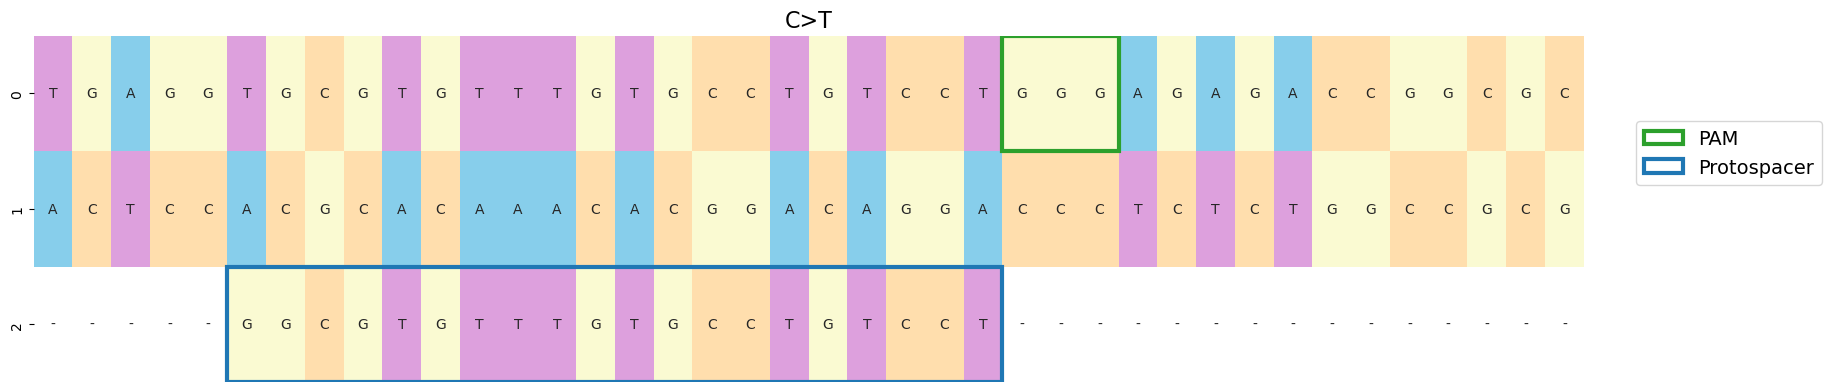

In [55]:
sensor_viz_base(b2, 1)

In [56]:
b2

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,PAM,PAM_strand,Protospacer_30,Protospacer,Protospacer_Location,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,TGG,-,TGAGGTGCGTGTTTGTGCCTGTCCTGGGAG,GTGCGTGTTTGTGCCTGTCC,5,38.0,TTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCG,TTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCG,forward,No Error
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGG,-,GAGGTGCGTGTTTGTGCCTGTCCTGGGAGA,GGCGTGTTTGTGCCTGTCCT,4,53.0,TGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGC,TGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGC,forward,No Error
2,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,...,AGG,+,CTGTGCGCCGGTCTCTCCCAGGACAGGCAC,GCGCCGGTCTCTCCCAGGAC,20,50.0,TCTGTGCGCCGGTCTCTCCCAGGACAGGCACAAACACGCA,TCTGTGCGCCGGTCTCTCCCAGGAAAGGCACAAACACGCA,forward,No Error
3,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,...,TGG,-,TGAGGTGCGTGTTTGTGCCTGTCCTGGGAG,GTGCGTGTTTGTGCCTGTCC,17,38.0,TTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCG,TTGAGGTGCGTGTTTGTGCCTTTCCTGGGAGAGACCGGCG,forward,No Error
4,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,...,GGG,-,GAGGTGCGTGTTTGTGCCTGTCCTGGGAGA,GGCGTGTTTGTGCCTGTCCT,16,53.0,TGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGC,TGAGGTGCGTGTTTGTGCCTTTCCTGGGAGAGACCGGCGC,forward,No Error
5,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,...,CGG,-,GTTTGTGCCTGTCCTGGGAGAGACCGGCGC,GTGCCTGTCCTGGGAGAGAC,7,48.0,TGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACAGAGGAA,TGTTTGTGCCTTTCCTGGGAGAGACCGGCGCACAGAGGAA,forward,No Error
6,2,TP53,17,7578239,7578239,stop_gained,Nonsense_Mutation,SNP,C,A,...,TGG,-,AAGGAAATTTGCGTGTGGAGTATTTGGATG,GAATTTGCGTGTGGAGTATT,14,38.0,GAAGGAAATTTGCGTGTGGAGTATTTGGATGACAGAAACA,GAAGGAAATTTGCGTGTGTAGTATTTGGATGACAGAAACA,forward,No Error
7,3,TP53,17,7577121,7577121,missense_variant,Missense_Mutation,SNP,G,A,...,TGG,-,TGAGGTGCGTGTTTGTGCCTGTCCTGGGAG,GTGCGTGTTTGTGCCTGTCC,4,38.0,TTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCG,TTGAGGTGTGTGTTTGTGCCTGTCCTGGGAGAGACCGGCG,forward,No Error
8,3,TP53,17,7577121,7577121,missense_variant,Missense_Mutation,SNP,G,A,...,GGG,-,GAGGTGCGTGTTTGTGCCTGTCCTGGGAGA,GGCGTGTTTGTGCCTGTCCT,3,53.0,TGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGC,TGAGGTGTGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGC,forward,No Error
9,4,TP53,17,7577506,7577506,missense_variant,Missense_Mutation,SNP,C,A,...,TGG,+,ACCTGGAGTCTTCCAGTGTGATGATGGTGA,GGAGTCTTCCAGTGTGATGA,6,56.0,GACCTGGAGTCTTCCAGTGTGATGATGGTGAGGATGGGCC,GACCTGGAGTATTCCAGTGTGATGATGGTGAGGATGGGCC,forward,No Error


In [317]:
sensor = df_w_sensor.iloc[i]['sensor_wt']
alt = df_w_sensor.iloc[i]['sensor_alt']

a = aligner.align(sensor, alt)
print(a[0])

ATGTCGAAAAGTGTTTCTGTCATCCAAATACTCCACACGCAAATTTCCTTCCACTCGGAT
||||||||||------------------------||||||||||||||||||||||||||
ATGTCGAAAA------------------------ACACGCAAATTTCCTTCCACTCGGAT



In [350]:
df_w_sensor[df_w_sensor['Variant_Type']=="INS"][350:400]

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error
17986,315,TP53,17,7578196,7578197,frameshift_variant,Frame_Shift_Ins,INS,-,CCACC,...,GGGGTGGTGCCCTATGAGCCGCCTGAGG,8,2,False,False,45.0,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,reverse-complement,No Error
17987,315,TP53,17,7578196,7578197,frameshift_variant,Frame_Shift_Ins,INS,-,CCACC,...,GGGGTGGTGCCCTATGAGCCGCCTGAGGTC,8,2,False,False,45.0,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,reverse-complement,No Error
17988,315,TP53,17,7578196,7578197,frameshift_variant,Frame_Shift_Ins,INS,-,CCACC,...,ATAGTGTGGTGGGGTGGTGCCCTATGAGCCGCC,8,12,False,False,45.0,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,reverse-complement,No Error
17989,315,TP53,17,7578196,7578197,frameshift_variant,Frame_Shift_Ins,INS,-,CCACC,...,ATAGTGTGGTGGGGTGGTGCCCTATGAGCCGCCTG,8,12,False,False,45.0,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,reverse-complement,No Error
17990,315,TP53,17,7578196,7578197,frameshift_variant,Frame_Shift_Ins,INS,-,CCACC,...,ATAGTGTGGTGGGGTGGTGCCCTATGAGCCGCCTGAGG,8,12,False,False,45.0,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,reverse-complement,No Error
17991,315,TP53,17,7578196,7578197,frameshift_variant,Frame_Shift_Ins,INS,-,CCACC,...,ATAGTGTGGTGGGGTGGTGCCCTATGAGCCGCCTGAGGTC,8,12,False,False,45.0,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,reverse-complement,No Error
17992,315,TP53,17,7578196,7578197,frameshift_variant,Frame_Shift_Ins,INS,-,CCACC,...,TCGACATAGTGTGGTGGGGTGGTGCCCTATGAGCCGCC,8,17,False,False,45.0,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,reverse-complement,No Error
17993,315,TP53,17,7578196,7578197,frameshift_variant,Frame_Shift_Ins,INS,-,CCACC,...,TCGACATAGTGTGGTGGGGTGGTGCCCTATGAGCCGCCTG,8,17,False,False,45.0,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,reverse-complement,No Error
17994,315,TP53,17,7578196,7578197,frameshift_variant,Frame_Shift_Ins,INS,-,CCACC,...,TCGACATAGTGTGGTGGGGTGGTGCCCTATGAGCCGCCTGAGG,8,17,False,False,45.0,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,reverse-complement,No Error
17995,315,TP53,17,7578196,7578197,frameshift_variant,Frame_Shift_Ins,INS,-,CCACC,...,TCGACATAGTGTGGTGGGGTGGTGCCCTATGAGCCGCCTGAGGTC,8,17,False,False,45.0,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,AATTTGCGTGTGGAGTATTTGGATGACAGAAACACTTTTCGACATA...,reverse-complement,No Error


In [288]:
df_w_sensor[df_w_sensor['PAM_disrupted']==True][0:50]

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted,sensor_wt,sensor_alt,sensor_error,sensor_orientation
76,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,...,8,CTTTCCTGGGAGA,2,2,True,True,GGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGA...,GGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTTTCCTGGGAGA...,No Error,reverse-complement
77,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,...,10,CTTTCCTGGGAGAGA,2,2,True,True,GGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGA...,GGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTTTCCTGGGAGA...,No Error,reverse-complement
78,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,...,13,CTTTCCTGGGAGAGACCG,2,2,True,True,GGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGA...,GGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTTTCCTGGGAGA...,No Error,reverse-complement
79,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,...,15,CTTTCCTGGGAGAGACCGGC,2,2,True,True,GGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGA...,GGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTTTCCTGGGAGA...,No Error,reverse-complement
120,2,TP53,17,7578239,7578239,stop_gained,Nonsense_Mutation,SNP,C,A,...,8,TACTACACACGCAAATTT,5,4,True,False,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTCCACACGCAAATTT...,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTACACACGCAAATTT...,No Error,reverse-complement
121,2,TP53,17,7578239,7578239,stop_gained,Nonsense_Mutation,SNP,C,A,...,10,TACTACACACGCAAATTTCC,5,4,True,False,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTCCACACGCAAATTT...,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTACACACGCAAATTT...,No Error,reverse-complement
122,2,TP53,17,7578239,7578239,stop_gained,Nonsense_Mutation,SNP,C,A,...,13,TACTACACACGCAAATTTCCTTC,5,4,True,False,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTCCACACGCAAATTT...,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTACACACGCAAATTT...,No Error,reverse-complement
123,2,TP53,17,7578239,7578239,stop_gained,Nonsense_Mutation,SNP,C,A,...,15,TACTACACACGCAAATTTCCTTCCA,5,4,True,False,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTCCACACGCAAATTT...,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTACACACGCAAATTT...,No Error,reverse-complement
124,2,TP53,17,7578239,7578239,stop_gained,Nonsense_Mutation,SNP,C,A,...,8,CCAAATACTACACACGCAAATTT,5,9,True,False,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTCCACACGCAAATTT...,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTACACACGCAAATTT...,No Error,reverse-complement
125,2,TP53,17,7578239,7578239,stop_gained,Nonsense_Mutation,SNP,C,A,...,10,CCAAATACTACACACGCAAATTTCC,5,9,True,False,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTCCACACGCAAATTT...,ATGTCGAAAAGTGTTTCTGTCATCCAAATACTACACACGCAAATTT...,No Error,reverse-complement


In [268]:
len(split_RTT_PBS)

60

In [259]:
proto = df_w_sensor.iloc[i]['Protospacer']
proto[::-1][:19]

'CCCTCTCTGGCCGCGTGTC'

In [242]:
myColors[3]

'lightgoldenrodyellow'

In [42]:
input_df = input_df.rename(columns = {'index':'mutation_idx'})

df = pd.merge(input_df, peg_df, on='mutation_idx')
df

,mutation_idx,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGC,10,ATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,0,False,False
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGCGCA,13,ATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCA,19,0,False,False
2,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGCGCACA,15,ATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA,19,0,False,False
3,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGCGCACAGA,17,ATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACAGA,19,0,False,False
4,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,TTTGAGGTGCATGTTTGTGCCTGTCCTGGG,30,AGAGACCGGC,10,TTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,10,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122567,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,CAGAATGCAATAAGCCCAGA,20,CGGAAACCGTAGCTGCC,17,CAGAATGCAATAAGCCCAGACGGAAACCGTAGCTGCC,9,10,False,False
122568,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,TTGGCTGTCCCAGAATGCAATAAGCCCAGA,30,CGGAAACCGT,10,TTGGCTGTCCCAGAATGCAATAAGCCCAGACGGAAACCGT,9,20,False,False
122569,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,TTGGCTGTCCCAGAATGCAATAAGCCCAGA,30,CGGAAACCGTAGC,13,TTGGCTGTCCCAGAATGCAATAAGCCCAGACGGAAACCGTAGC,9,20,False,False
122570,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,TTGGCTGTCCCAGAATGCAATAAGCCCAGA,30,CGGAAACCGTAGCTG,15,TTGGCTGTCCCAGAATGCAATAAGCCCAGACGGAAACCGTAGCTG,9,20,False,False


In [27]:
class bcolors:
    Red = '\033[91m'
    Green = '\033[92m'
    Blue = '\033[94m'
    Cyan = '\033[96m'
    White = '\033[97m'
    Yellow = '\033[93m'
    Magenta = '\033[95m'
    Grey = '\033[90m'
    ENDC = '\033[0m'

from Bio import pairwise2

def visualize_pegRNA(df, i):
    """
    This one visualizes the binding of the protospacer and the 3' extension to the ref seq
    It also says the rank and PRIDICT score (intended/unintended editing)

    Inputs:
    df = datframe (loaded from pegRNA_dataframe.csv)
    i = index (row/pegRNA that you want to visualize the mutation from;
            will change depending on the strand (Reverse or Forward) of the pegRNA)
    """

    if df['PAM_strand'][i] == '+':
        refseq = df['wt_w_context'][i]
    else:
        refseq = df['wt_w_context'][i]
        refseq = str(Bio.Seq.Seq(refseq).reverse_complement())
        


    proto = df['Protospacer'][i]

    #print a bunch of info about the pegRNA
    #print( bcolors.ENDC + 'pegRNA Rank = ' + str(df['rank'][i]))
    print('Target Strand = ' + df['PAM_strand'][i])
    print(str(df['Variant_Type'][i]) +': ' + str(df['REF'][i]) + '/' + str(df['ALT'][i]))
    print('PBS length = ' + str(df['PBS_length'][i]) + ' ; RT length = '+ str(df['RTT_length'][i]) + '; RT overhang = ' + str(df['RHA_size'][i]))


    proto_loc = refseq.find(proto[1:])

    #RT = Bio.Seq.Seq(df['RTrevcomp'][i]).reverse_complement()
    ext = Bio.Seq.Seq(df['RTT_PBS'][i]).reverse_complement()

    first = pairwise2.align.localms(refseq, ext, 2,0, -3, -0.2)[0]
    a=format_alignment(*first, full_sequences=True)

    start = len(first.seqB) + 1
    end = 2*len(first.seqB) + 1
    pipes = a[start:end]

    #translating first.seqB into complement (the true 3' extension)
    dict_comp = {'-':'-', 'A':'T', 'T':'A', 'C':'G', 'G':'C'}
    comp1 = [dict_comp[i] for i in first.seqB]
    complement = "".join(comp1)

    print(complement + '\n' + pipes + '\n' + first.seqA[0:proto_loc] + bcolors.Blue + first.seqA[proto_loc:proto_loc+19] + bcolors.Magenta + first.seqA[proto_loc+19:proto_loc+22] + bcolors.ENDC + first.seqA[proto_loc+22:] )
    print(Bio.Seq.Seq(first.seqA).complement())

    second = pairwise2.align.localms(refseq, proto, 2,0, -3, -0.2)[0]
    b=format_alignment(*second, full_sequences=True)

    start2 = len(second.seqB) + 1
    end2 = 2*len(second.seqB) + 1
    pipes2 = b[start:end]

    #print(' ' + pipes2)
    print(pipes2)
    print(second.seqB)

    print(bcolors.Blue + 'Protospacer (G+19 bp)')
    print(bcolors.Magenta + 'PAM')
    print('\n')

In [28]:
visualize_pegRNA(df, 20228)

NameError: name 'df' is not defined

In [799]:
len('ACGTGGTCGTCGAGGAT')

17

In [818]:
df[df['Variant_Type']=='INS'][-1000:]

,mutation_idx,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
27228,792,TP53,17,7577035,7577036,frameshift_variant,Frame_Shift_Ins,INS,-,G,...,GCCTCGCTTAGTGCTCCCTG,CACCACGAGCTGCCCCCCAG,20,GGAGCACTAA,10,CACCACGAGCTGCCCCCCAGGGAGCACTAA,2,17,False,True
27229,792,TP53,17,7577035,7577036,frameshift_variant,Frame_Shift_Ins,INS,-,G,...,GCCTCGCTTAGTGCTCCCTG,CACCACGAGCTGCCCCCCAG,20,GGAGCACTAAGCG,13,CACCACGAGCTGCCCCCCAGGGAGCACTAAGCG,2,17,False,True
27230,792,TP53,17,7577035,7577036,frameshift_variant,Frame_Shift_Ins,INS,-,G,...,GCCTCGCTTAGTGCTCCCTG,CACCACGAGCTGCCCCCCAG,20,GGAGCACTAAGCGAG,15,CACCACGAGCTGCCCCCCAGGGAGCACTAAGCGAG,2,17,False,True
27231,792,TP53,17,7577035,7577036,frameshift_variant,Frame_Shift_Ins,INS,-,G,...,GCCTCGCTTAGTGCTCCCTG,CACCACGAGCTGCCCCCCAG,20,GGAGCACTAAGCGAGGT,17,CACCACGAGCTGCCCCCCAGGGAGCACTAAGCGAGGT,2,17,False,True
27232,792,TP53,17,7577035,7577036,frameshift_variant,Frame_Shift_Ins,INS,-,G,...,GCCTCGCTTAGTGCTCCCTG,AGGGGAGCCTCACCACGAGCTGCCCCCCAG,30,GGAGCACTAA,10,AGGGGAGCCTCACCACGAGCTGCCCCCCAGGGAGCACTAA,2,27,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33963,982,TP53,17,7578479,7578480,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GACCTGCCCTGTGCAGCTGT,GGATGTGGAATCAACCCACA,20,GCTGCACAGGGCAGGTC,17,GGATGTGGAATCAACCCACAGCTGCACAGGGCAGGTC,17,2,False,False
33964,982,TP53,17,7578479,7578480,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GACCTGCCCTGTGCAGCTGT,GCCGGGCGGGGGATGTGGAATCAACCCACA,30,GCTGCACAGG,10,GCCGGGCGGGGGATGTGGAATCAACCCACAGCTGCACAGG,17,12,False,False
33965,982,TP53,17,7578479,7578480,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GACCTGCCCTGTGCAGCTGT,GCCGGGCGGGGGATGTGGAATCAACCCACA,30,GCTGCACAGGGCA,13,GCCGGGCGGGGGATGTGGAATCAACCCACAGCTGCACAGGGCA,17,12,False,False
33966,982,TP53,17,7578479,7578480,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GACCTGCCCTGTGCAGCTGT,GCCGGGCGGGGGATGTGGAATCAACCCACA,30,GCTGCACAGGGCAGG,15,GCCGGGCGGGGGATGTGGAATCAACCCACAGCTGCACAGGGCAGG,17,12,False,False


In [786]:
len('ATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA')

35

In [782]:
Bio.Seq.Seq(df.iloc[1]['RTT_PBS']).reverse_complement()

Seq('TGCGCCGGTCTCTCCCAGGACAGGCACAAACAT')

In [1]:
df

NameError: name 'df' is not defined

In [780]:
len('GCCGGTCTCTCCCAGGACAGGCACAAACAT')

30

# Protospacer ranking

https://github.com/gpp-rnd/rs3

https://github.com/microsoftResearch//azimuth

https://pypi.org/project/Biomatters-Azimuth-2/


This seems like the best option: https://github.com/crisprVerse/crisprScore

Use in python: https://willfondrie.com/2022/01/how-to-use-r-packages-in-python/

May be able to get this to work: https://github.com/crisprVerse/crisprScore/blob/master/inst/python/rs3/targetfeat.py

> Modify these and port them into my workspace...

In [96]:
# This code is adopted from CRISPOR program with minor modifications
# https://github.com/maximilianh/crisporWebsite
# "Evaluation of off-target and on-target scoring algorithms and integration into the guide RNA selection tool CRISPOR"
# by M. Haeussler et al. 2016

import math
 
params = [
# pasted/typed table from PDF and converted to zero-based positions
(1,'G',-0.2753771),(2,'A',-0.3238875),(2,'C',0.17212887),(3,'C',-0.1006662),
(4,'C',-0.2018029),(4,'G',0.24595663),(5,'A',0.03644004),(5,'C',0.09837684),
(6,'C',-0.7411813),(6,'G',-0.3932644),(11,'A',-0.466099),(14,'A',0.08537695),
(14,'C',-0.013814),(15,'A',0.27262051),(15,'C',-0.1190226),(15,'T',-0.2859442),
(16,'A',0.09745459),(16,'G',-0.1755462),(17,'C',-0.3457955),(17,'G',-0.6780964),
(18,'A',0.22508903),(18,'C',-0.5077941),(19,'G',-0.4173736),(19,'T',-0.054307),
(20,'G',0.37989937),(20,'T',-0.0907126),(21,'C',0.05782332),(21,'T',-0.5305673),
(22,'T',-0.8770074),(23,'C',-0.8762358),(23,'G',0.27891626),(23,'T',-0.4031022),
(24,'A',-0.0773007),(24,'C',0.28793562),(24,'T',-0.2216372),(27,'G',-0.6890167),
(27,'T',0.11787758),(28,'C',-0.1604453),(29,'G',0.38634258),(1,'GT',-0.6257787),
(4,'GC',0.30004332),(5,'AA',-0.8348362),(5,'TA',0.76062777),(6,'GG',-0.4908167),
(11,'GG',-1.5169074),(11,'TA',0.7092612),(11,'TC',0.49629861),(11,'TT',-0.5868739),
(12,'GG',-0.3345637),(13,'GA',0.76384993),(13,'GC',-0.5370252),(16,'TG',-0.7981461),
(18,'GG',-0.6668087),(18,'TC',0.35318325),(19,'CC',0.74807209),(19,'TG',-0.3672668),
(20,'AC',0.56820913),(20,'CG',0.32907207),(20,'GA',-0.8364568),(20,'GG',-0.7822076),
(21,'TC',-1.029693),(22,'CG',0.85619782),(22,'CT',-0.4632077),(23,'AA',-0.5794924),
(23,'AG',0.64907554),(24,'AG',-0.0773007),(24,'CG',0.28793562),(24,'TG',-0.2216372),
(26,'GT',0.11787758),(28,'GG',-0.69774)]
 
intercept =  0.59763615
gc_high    = -0.1665878
gc_low     = -0.2026259
 
def calc_doench_score(seq):
  score = intercept
 
  #guide = seq[4:24]
  guide = seq
  gc_count = guide.count('G') + guide.count('C')
  gc_weight = gc_low if gc_count <= 10 else gc_high
  score += abs(10-gc_count)*gc_weight
 
  for pos, model_seq, weight in params:
    sub_seq = seq[pos:pos+len(model_seq)]
    if sub_seq == model_seq:
      score += weight
  total_score = 1.0/(1.0+math.exp(-score)) * 100
  return total_score

In [40]:
seqs = ['AGAGAGATTCTTGCTCACCGTCTGTGGAGA',
'AGAGAGATTCTTGCTCACCGTCTGCGGAGA',
'AGAGAGATTCTTCATCACCGTCTGCGGAGA',
'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGG']

[calc_doench_score(seq) for seq in seqs]

['3.911', '8.716', '15.631', '0.019']

In [2]:
#rs2/Azimuth

import crisporEffScores


[58]

In [41]:

seqs = ['AGAGAGATTCTTGCTCACCGTCTGTGGAGA',
'AGAGAGATTCTTGCTCACCGTCTGCGGAGA',
'AGAGAGATTCTTCATCACCGTCTGCGGAGA',
'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGG']

#3 extra on the PAM side; 4 extra on protospacer side


scores = crisporEffScores.calcAziScore(seqs)
scores

[58, 63, 67, 9]

In [42]:
#checking how closely it matches up with previously calculated scores...

p53_lib = pd.read_csv('/Users/samgould/Desktop/FSR Lab/Manuscripts/p53 PE sensor/final submission/Supplemental/Supplemental-Table-1_pegRNAs.csv')

In [43]:
p53_lib.keys()

Index(['peg_id', 'variant_index', 'HGVSp', 'HGVSc', 'gene', 'chr', 'start',
       'end', 'variant_type', 'classification', 'consequence', 'ref_allele',
       'mut_allele', 'codon', 'Domain', 'num_occurences', 'WT_sensor',
       'CorrectEdit_sensor', 'PAM_location', 'PAM_strand', 'PAM',
       'protospacer', 'PBS', 'PBS_length', 'RTT', 'RTT_length', 'PBS_RTT_5to3',
       'epegRNA_tevopreQ1_full', 'PBS_GC_content', 'distance_to_nick',
       'homology_overhang', 'MIT_specificity', 'Doench16_Azimuth_percentile',
       'PEGG_score', 'wt_qwc', 'edit_qwc'],
      dtype='object')

In [48]:
chr17 = chrom_dict[17]

In [69]:
PAM_locs = np.unique(p53_lib[p53_lib['PAM_strand']=='+']['PAM_location'])

seq_holder = []
for i in range(len(PAM_locs)):
    a = str(chr17[PAM_locs[i]-20-4:PAM_locs[i]+3+3]).upper()
    
    seq_holder.append(a)

In [97]:
rs1 = [calc_doench_score(seq) for seq in seq_holder]

In [80]:

plus = p53_lib[p53_lib['PAM_strand']=='+']
score_ucsc = []
for i in PAM_locs:
    b = plus[plus['PAM_location']==i]['Doench16_Azimuth_percentile'].values[0]
    score_ucsc.append(b)

In [76]:
scores = crisporEffScores.calcAziScore(seq_holder)

Text(0, 0.5, 'Calculated Azimuth Score')

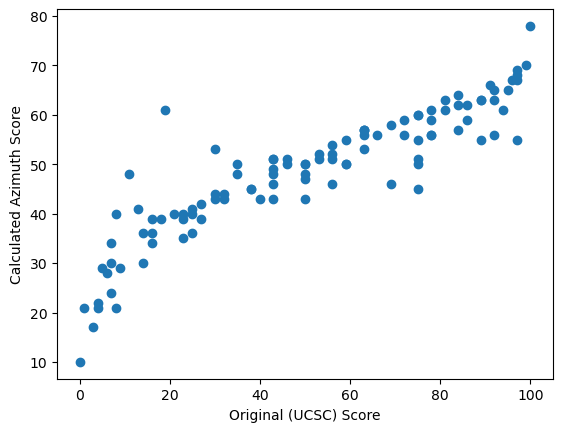

In [90]:
import scipy.stats
plt.scatter(score_ucsc, scores)
scipy.stats.spearmanr(score_ucsc, scores)
plt.xlabel('Original (UCSC) Score')
plt.ylabel('Calculated Azimuth Score')

PearsonRResult(statistic=0.4589664768146063, pvalue=7.488671911605457e-07)

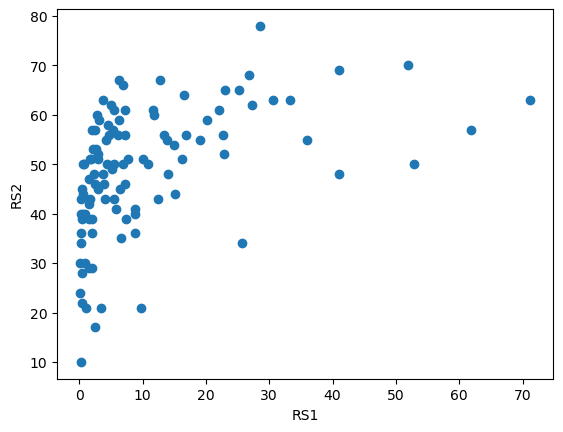

In [102]:
plt.scatter(rs1, scores)

plt.xlabel('RS1')
plt.ylabel('RS2')
scipy.stats.pearsonr(rs1, scores)

# Checking the python script

In [3]:
import sys
sys.path.insert(0, 'pegg')

from pegg.prime import pegg2

In [1]:
import sys
sys.path.insert(0, 'pegg')

from pegg.base import base_editing

In [2]:
filepath_37 = '/Users/samgould/Desktop/FSR Lab/reference files/GRCh37/ncbi-genomes-2022-03-17/GCF_000001405.25_GRCh37.p13_genomic.fna.gz'
filepath_38 = '/Users/samgould/Desktop/FSR Lab/reference files/GRCh38/ncbi-genomes-2022-02-23/GCF_000001405.26_GRCh38_genomic.fna.gz'
mouse = '/Users/samgould/Desktop/FSR Lab/reference files/GRCm38.p6 (mouse)/ncbi-genomes-2022-04-04/GCF_000001635.26_GRCm38.p6_genomic.fna.gz'
chrom_dict, i = base_editing.pegg2.genome_loader(filepath_37)

In [3]:
import pandas as pd
impact = pd.read_csv('/Users/samgould/Desktop/FSR Lab/reference files/2020-06-16-MSK-IMPACT_EDITED.txt', sep='\t')

p53 = impact[impact['Hugo_Symbol']=='TP53'].drop_duplicates(subset='HGVSc')

#or change these to INDELs
dels1 = p53[p53['Variant_Type']=='DEL']
bad_del_idx = list(dels1[dels1['Tumor_Seq_Allele2']!='-'].index)

ins1 = p53[p53['Variant_Type']=='INS']
bad_ins_idx = list(ins1[ins1['Reference_Allele']!='-'].index)

bad_idxs = bad_del_idx + bad_ins_idx

p53_filtered = p53.drop(index=bad_idxs).reset_index().drop(columns=['index'])

In [19]:
input = p53_filtered[0:16]
input_format = 'cBioPortal'

b2 = base_editing.run_base(input, input_format, chrom_dict, sensor=True, PAM='NRCH')

In [20]:
b2

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,PAM,PAM_strand,Protospacer_30,Protospacer,Protospacer_Location,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,CACC,+,TCTCCCAGGACAGGCACAAACACGCACCTC,GCAGGACAGGCACAAACACG,19,71.0,AACAGCTTTGAGGTGCGTGTTTGTGCCTGTCCTGGGAGAG,AACAGCTTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAG,reverse-complement,No Error
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,AGCT,+,GACAGGCACAAACACGCACCTCAAAGCTGT,GGCACAAACACGCACCTCAA,11,59.0,TGGGACGGAACAGCTTTGAGGTGCGTGTTTGTGCCTGTCC,TGGGACGGAACAGCTTTGAGGTGCATGTTTGTGCCTGTCC,reverse-complement,No Error
2,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,TGCC,-,GAACAGCTTTGAGGTGCGTGTTTGTGCCTG,GGCTTTGAGGTGCGTGTTTG,14,47.0,CTCCCAGGACAGGCACAAACACGCACCTCAAAGCTGTTCC,CTCCCAGGACAGGCACAAACATGCACCTCAAAGCTGTTCC,reverse-complement,No Error
3,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,...,GGCA,+,TGTGCGCCGGTCTCTCCCAGGACAGGCACA,GGCCGGTCTCTCCCAGGACA,19,57.0,GTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACAG,GTGCGTGTTTGTGCCTTTCCTGGGAGAGACCGGCGCACAG,reverse-complement,No Error
4,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,...,CACA,+,TGCGCCGGTCTCTCCCAGGACAGGCACAAA,GCGGTCTCTCCCAGGACAGG,17,60.0,AGGTGCGTGTTTGTGCCTGTCCTGGGAGAGACCGGCGCAC,AGGTGCGTGTTTGTGCCTTTCCTGGGAGAGACCGGCGCAC,reverse-complement,No Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,15,TP53,17,7578443,7578443,missense_variant,Missense_Mutation,SNP,A,T,...,GGCC,+,CATGTGCTGTGACTGCTTGTAGATGGCCAT,GGCTGTGACTGCTTGTAGAT,17,45.0,GTCCGCGCCATGGCCATCTACAAGCAGTCACAGCACATGA,GTCCGCGCCATGGCCATCAACAAGCAGTCACAGCACATGA,reverse-complement,No Error
71,15,TP53,17,7578443,7578443,missense_variant,Missense_Mutation,SNP,A,T,...,AGCA,-,GCGTCCGCGCCATGGCCATCTACAAGCAGT,GCGCGCCATGGCCATCTACA,17,50.0,TGTGCTGTGACTGCTTGTAGATGGCCATGGCGCGGACGCG,TGTGCTGTGACTGCTTGTTGATGGCCATGGCGCGGACGCG,reverse-complement,No Error
72,15,TP53,17,7578443,7578443,missense_variant,Missense_Mutation,SNP,A,T,...,CACA,-,GCGCCATGGCCATCTACAAGCAGTCACAGC,GATGGCCATCTACAAGCAGT,11,65.0,CCGTCATGTGCTGTGACTGCTTGTAGATGGCCATGGCGCG,CCGTCATGTGCTGTGACTGCTTGTTGATGGCCATGGCGCG,reverse-complement,No Error
73,15,TP53,17,7578443,7578443,missense_variant,Missense_Mutation,SNP,A,T,...,AGCA,-,CCATGGCCATCTACAAGCAGTCACAGCACA,GGCCATCTACAAGCAGTCAC,8,56.0,CCTCCGTCATGTGCTGTGACTGCTTGTAGATGGCCATGGC,CCTCCGTCATGTGCTGTGACTGCTTGTTGATGGCCATGGC,reverse-complement,No Error


In [17]:
for i, val in b2.iterrows():
    ps = val['Protospacer_Location']
    strand = val['PAM_strand']
    protowide = val['Protospacer_30']
    ref = val['REF']
    proto = val['Protospacer']

    print(f'Strand = {strand} | ref = {ref} | inproto = {protowide[4+ps-1]} | proto_small = {proto[ps-1]} | {ps}')


Strand = + | ref = C | inproto = C | proto_small = C | 19
Strand = + | ref = C | inproto = C | proto_small = C | 11
Strand = - | ref = C | inproto = G | proto_small = G | 14
Strand = + | ref = C | inproto = C | proto_small = C | 19
Strand = + | ref = C | inproto = C | proto_small = C | 17
Strand = + | ref = C | inproto = C | proto_small = C | 13
Strand = + | ref = C | inproto = C | proto_small = C | 9
Strand = + | ref = C | inproto = C | proto_small = C | 7
Strand = - | ref = C | inproto = G | proto_small = G | 10
Strand = - | ref = C | inproto = G | proto_small = G | 4
Strand = - | ref = C | inproto = G | proto_small = G | 2
Strand = + | ref = C | inproto = C | proto_small = C | 20
Strand = + | ref = C | inproto = C | proto_small = C | 16
Strand = + | ref = C | inproto = C | proto_small = C | 2
Strand = - | ref = C | inproto = G | proto_small = G | 9
Strand = - | ref = C | inproto = G | proto_small = G | 3
Strand = - | ref = C | inproto = G | proto_small = G | 1
Strand = + | ref = G |

In [13]:
b2['Protospacer_Location'][0]

'5'

In [10]:
b2['Protospacer']

0     GTGCGTGTTTGTGCCTGTCC
1     GGCGTGTTTGTGCCTGTCCT
2     GCGCCGGTCTCTCCCAGGAC
3     GTGCGTGTTTGTGCCTGTCC
4     GGCGTGTTTGTGCCTGTCCT
5     GTGCCTGTCCTGGGAGAGAC
6     GAATTTGCGTGTGGAGTATT
7     GTGCGTGTTTGTGCCTGTCC
8     GGCGTGTTTGTGCCTGTCCT
9     GGAGTCTTCCAGTGTGATGA
10    GTTCCAGTGTGATGATGGTG
11    GCATCACACTGGAAGACTCC
12    GCACTGGAAGACTCCAGGTC
13    GCGGTTCATGCCGCCCATGC
14    GCTGCATGGGCGGCATGAAC
15    GCATGGGCGGCATGAACCGG
16    GATGGCGCGGACGCGGGTGC
17    GTGGCGCGGACGCGGGTGCC
18    GCGCGGACGCGGGTGCCGGG
19    GGCGGACGCGGGTGCCGGGC
20    GCGGACGCGGGTGCCGGGCG
21    GGGACGCGGGTGCCGGGCGG
22    GCGGGTGCCGGGCGGGGGTG
23    GGGCACCCGCGTCCGCGCCA
24    GCGGTTCATGCCGCCCATGC
25    GCATGGGCGGCATGAACCGG
26    GCGGTTCATGCCGCCCATGC
27    GCTGCATGGGCGGCATGAAC
28    GCATGGGCGGCATGAACCGG
Name: Protospacer, dtype: object

In [15]:
#peg_df = pegg2.run(input, input_format, chrom_dict, sensor_length=100, before_proto_context=20) #, sensor_orientation='forward',)
input = p53_filtered[0:10]
input_format = 'cBioPortal'
p2 = pegg2.run(input, input_format, chrom_dict, sensor_length=100, before_proto_context=20) #, sensor_orientation='forward',)

NameError: name 'p53_filtered' is not defined

In [6]:
p2

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
2,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCA,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
3,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
4,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,TTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,10,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,9,TP53,17,7577547,7577547,missense_variant,Missense_Mutation,SNP,C,A,...,GATGGGCCTCCGGTTCATGACGCCCATGCAGGAACTGTTA,5,19,True,False,64.0,GCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGTGAGGATGGGCC...,GCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGTGAGGATGGGCC...,reverse-complement,No Error
728,9,TP53,17,7577547,7577547,missense_variant,Missense_Mutation,SNP,C,A,...,GTGAGGATGGGCCTCCGGTTCATGACGCCCATGCAGGA,5,24,True,False,64.0,GCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGTGAGGATGGGCC...,GCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGTGAGGATGGGCC...,reverse-complement,No Error
729,9,TP53,17,7577547,7577547,missense_variant,Missense_Mutation,SNP,C,A,...,GTGAGGATGGGCCTCCGGTTCATGACGCCCATGCAGGAAC,5,24,True,False,64.0,GCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGTGAGGATGGGCC...,GCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGTGAGGATGGGCC...,reverse-complement,No Error
730,9,TP53,17,7577547,7577547,missense_variant,Missense_Mutation,SNP,C,A,...,GTGAGGATGGGCCTCCGGTTCATGACGCCCATGCAGGAACTGT,5,24,True,False,64.0,GCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGTGAGGATGGGCC...,GCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGTGAGGATGGGCC...,reverse-complement,No Error


In [102]:
input = p53_filtered[0:1000]
input_format = 'cBioPortal'
peg_df = pegg2.run(input, input_format, chrom_dict, sensor_length=100, before_proto_context=20) #, sensor_orientation='forward',)
peg_df

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted,OnTarget_Azimuth_Score,sensor_wt,sensor_alt,sensor_orientation,sensor_error
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
2,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCA,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
3,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA,19,5,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
4,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,TTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,10,False,False,43.0,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCGTG...,CTGAGTAGTGGTAATCTACTGGGACGGAACAGCTTTGAGGTGCATG...,reverse-complement,No Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58431,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,GGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGGTG,1,24,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error
58432,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCT,1,29,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error
58433,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGC,1,29,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error
58434,999,TP53,17,7579444,7579444,frameshift_variant,Frame_Shift_Del,DEL,T,-,...,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGG,1,29,True,True,61.0,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,TTTTCTGGGAAGGGACAGAAGATGACAGGGGCCAGGAGGGGGCTGG...,reverse-complement,No Error


# Error checking


In [4]:
from Bio.Align import PairwiseAligner
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [64]:
def sensor_outcome_corrected(p53_lib, i):
    #p53_lib = df containing pegRNA + target sequence + other info
    #i = index

    sensor_true = p53_lib.iloc[i]['wt_w_context']

    #let's quantify the homology overhang as well...
    PAM_strand = p53_lib.iloc[i]['PAM_strand']
    var_type = p53_lib.iloc[i]['Variant_Type']


    if PAM_strand=='+':
        sensor = Bio.Seq.Seq(p53_lib.iloc[i]['wt_w_context']).reverse_complement()

    elif PAM_strand=='-':
        sensor = p53_lib.iloc[i]['wt_w_context']

    pbs_length = p53_lib.iloc[i]['PBS_length']
    pbs = p53_lib.iloc[i]['RTT_PBS'][-pbs_length:]
    rtt = p53_lib.iloc[i]['RTT_PBS'][:-(pbs_length-1)] #FIXING [:-0] indexing issue...

    #pbs_rtt = p53_lib.iloc[i]['PBS_RTT_5to3']

    pbs_find = sensor.find(pbs)
    #print(pbs_find)

    #first compute the portion before the mutation for computing the right flank
    for kk, val in enumerate(reversed(rtt)):
        idx = pbs_find-kk
        if val!= sensor[idx]: #find first mismatch
            mut_start=kk
            break
        else:
            continue


    try: mut_start
    except: #case where's theres no identifiable change (because of homology overhang being too short/matching coincidentally...)
        return sensor_true, sensor_true, 0, "no homology overhang"

    #alignments = aligner.align(pbs, sensor)
    #print(alignments[0])

    #alignments = aligner.align(rtt, sensor)
    #print(alignments[0])

    #now we have the right flank...
    right_flank = rtt[-mut_start:-1] + sensor[pbs_find:]

    #alignments = aligner.align(right_flank, sensor)
    #print(alignments[0])
    
    if var_type in ['SNP', 'ONP']:

        matching_arr = np.zeros(len(rtt[:-mut_start]))

        for kk, val in enumerate(reversed(rtt[:-mut_start])):
            idx = pbs_find-mut_start-kk

            if val== sensor[idx]: #find regions of homology
                matching_arr[kk]+=1
                
            else:
                continue
        
        #based on values in match array, determine where mutation vs. homology overhang is...
        end_mut = np.where(matching_arr==0)[0][-1]

        mut_allele = rtt[-(mut_start+end_mut+1):-mut_start]
        homology_overhang = rtt[:-(mut_start+end_mut+1)]
        #this formulation will NOT catch situations where the homology overhang doesn't match???????
        #(though this shouldn't be an issue for SNPs/ONPs)

        left_flank = sensor[:(pbs_find-(len(rtt)-1))]

    elif var_type=='DEL':

        #find the size of the deletion by shifting and checking for matches...
        #will allow for detection of insufficient homology overhang...
        length_remaining = len(rtt[:-mut_start])
        homology_overhang = rtt[:-mut_start]
        mut_allele = ''

        start_idx = pbs_find-mut_start
        for i in range(len(sensor[:start_idx])): #check rest of the sensor...
        
            #sliding window to find size of deletion/perfect match...
            sensor_a = sensor[start_idx-i-length_remaining:start_idx-i]

            if sensor_a==homology_overhang: #once match is found, record and break...
                size_del = i
                break
        
            else:
                continue

        #error where the full homology overhang region not included in sensor...
        try: size_del
        except: 
            return sensor_true, sensor_true, len(homology_overhang), 'sensor too short' #no excepted editing, return WT sensor

        left_flank = sensor[:start_idx-size_del-length_remaining]

    elif var_type=='INS':

        length_remaining = len(rtt[:-mut_start])
        start_idx = pbs_find-mut_start+1

        for i in range(length_remaining):
            rtt_region = rtt[:-(mut_start+i)]
            sensor_a = sensor[start_idx-len(rtt_region):start_idx]

            #print('rt: ' + rtt_region)
            #print('s: ' + sensor_a)

            if sensor_a==rtt_region:
                mut_allele = rtt[-(mut_start+i):-mut_start]
                break
            else:
                continue

        #in case of no homology overhang...
        try: mut_allele
        except: 
            return sensor_true, sensor_true, 0, 'no homology overhang' #no excepted editing, return WT sensor

        homology_overhang = sensor_a
        left_flank = sensor[:start_idx-len(rtt_region)]

    edited_sensor = left_flank + homology_overhang + mut_allele + right_flank      

    if PAM_strand=='+':
        edited_sensor_true = str(Bio.Seq.Seq(edited_sensor).reverse_complement())

    elif PAM_strand=='-':
        edited_sensor_true=edited_sensor



    #alignments = aligner.align(rtt[-mut_start:], sensor)
    #print(alignments[0])

    #alignments = aligner.align(right_flank, sensor)
    #print(alignments[0])

    #alignments = aligner.align(homology_overhang, sensor)
    #print(alignments[0])

    #alignments = aligner.align(edited_sensor, sensor)
    #print(alignments[0])

    #alignments = aligner.align(edited_sensor_true, sensor_true)
    #print(alignments[0])


    return sensor_true, edited_sensor_true, len(homology_overhang), 'no error'

In [80]:

p53_lib = df[:50000]

#running it for every mutation in the p53 library
edit_sens = []
homo = []
idx_holder = []
classif = []
#del_idx = p53_del.index

#ins_idx = p53_lib[p53_lib['variant_type']=='SNP'].index

error = []
for i in range(len(p53_lib)):
    try:
        s, s_e, homo2, m = sensor_outcome_corrected(p53_lib, i)
        idx_holder.append(i)
        edit_sens.append(s_e)
        homo.append(homo2)
        classif.append(m)

        assert s_e == p53_lib['alt_w_context']
    
    except:
        error.append(i)

In [82]:
np.unique(classif, return_counts=True)

(array(['no error', 'no homology overhang', 'sensor too short'],
       dtype='<U20'),
 array([46234,  1972,    66]))

In [83]:
classif.index('sensor too short')

19976

In [84]:
df.iloc[[19976]]

,mutation_idx,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
19976,494,TP53,17,7578285,7578288,"frameshift_variant,splice_region_variant",Frame_Shift_Del,DEL,CAGA,-,...,GTTCCTCACTGATTGCTCTT,TCGGATAAGATGCTGAGGAGGGGCCCTAAG,30,AGCAATCAGT,10,TCGGATAAGATGCTGAGGAGGGGCCCTAAGAGCAATCAGT,6,24,False,False
